### Import das Bibliotecas

In [1]:
import os
import re
import librosa
import librosa.display

from sklearn.cluster import KMeans

import time
import pandas as pd
import numpy as np
import soundfile as sf

import IPython.display as ipd1
import matplotlib.pyplot as plt

from pathlib import Path

### Definição de Constantes

In [2]:
FFT_FRAME_SIZE = 2048
HOP_LENGTH = 1024

SEG_FRAME_SIZE = 105235
OFFSET_SIZE = 10000

### Carregamento do Dataframe com os Diretórios dos Áudios

In [3]:
dsPath = '.\\Datasets\\Projeto\\'
dsInfo = pd.read_csv(dsPath+'DiretoriosEventos.csv',sep=';')  

### Remoção dos Itens Gunshot  para Processamento Apenas de Itens ESC50

In [4]:
dsInfo.drop(dsInfo[~dsInfo['Diretorio'].isin(['CracklingFire','WaterDrops','GlassBreaking'])].index, inplace=True)
dsInfo

Diretorio           Evento
1  CracklingFire         Incêndio
2  GlassBreaking  Vidro Quebrando
3     WaterDrops    Água Pingando

### Carregamento dos Arquivos de Áudios e Remoção dos Zeros a Esquerda e Direita

In [5]:
count = 0
tamMaiorAudio =0
qtdArqSubDir = list()
allArqAudio = list()

print('inicio')
inicio = time.time()

for subdir in dsInfo['Diretorio']:
    dirPath = Path(dsPath+'\\AudiosOriginais\\'+subdir)
    arqObjectsPath = list(dirPath.glob('**/*.wav'))
    qtdArqSubDir.append(len(arqObjectsPath))
    
    for x in arqObjectsPath:
        count = count + 1
        audSignal, audSR = librosa.load(x, sr=44100)
        audSignal = np.trim_zeros(audSignal)
        allArqAudio.append([subdir, x, audSignal, len(audSignal)])
        
print(count)
fim = time.time()
print('fim - duração {0}'.format(fim-inicio))
    
dsInfo['QtdArq'] = qtdArqSubDir

inicio
120
fim - duração 8.361258506774902


### Conversão da Lista de Áudios em Dataframe e Gráfico Distribuição por Tamanho

<AxesSubplot:ylabel='Frequency'>

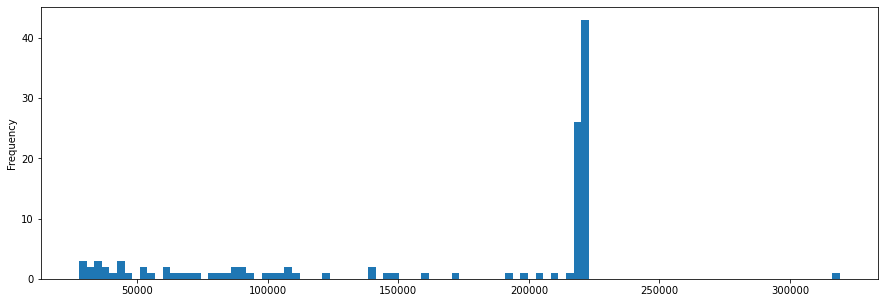

In [6]:
allArqAudioDF = pd.DataFrame(allArqAudio,columns=['diretorio','path','audio','tamanho'])
plt.figure(figsize=(15, 5))
allArqAudioDF['tamanho'].plot.hist(bins=100)

### Total de Áudios por Tipo

In [7]:
allArqAudioDF.groupby(['diretorio']).count()

path  audio  tamanho
diretorio                          
CracklingFire    40     40       40
GlassBreaking    40     40       40
WaterDrops       40     40       40

### Estatísticas dos Tamanhos do Áudios

In [8]:
allArqAudioDF['tamanho'].describe()

count       120.000000
mean     166548.366667
std       74416.936961
min       27646.000000
25%       90646.500000
50%      219446.500000
75%      220288.000000
max      319102.000000
Name: tamanho, dtype: float64

### Declaração da Função de Clustering das Frequências

In [9]:
def centroAltaFrequencia(signal):
    kmeans = None
    
    if(audSignal.size > 210000):
        kmeans = KMeans(n_clusters=3, random_state=0).fit(abs(audSignal).reshape(-1,1))
    elif(audSignal.size > 105000):
        kmeans = KMeans(n_clusters=2, random_state=0).fit(abs(audSignal).reshape(-1,1))

    if kmeans != None:
        print(kmeans.cluster_centers_)
        return max(kmeans.cluster_centers_)
    else:
        return None

### Declaração da Função de Segmentação dos Áudios Maiores e Menores que o Tamanho Definido


In [10]:
def audioSegmentation(audio, frameSize, offSetSize):   
    audioSplit = list()
    
    if len(audio) < frameSize:
        sizeDiff = frameSize-len(audio)
        qtdOffset = sizeDiff // offSetSize
        for x in range(qtdOffset):
            audioTemp = None
            audioTemp = np.append(np.zeros(x*offSetSize), audio)
            audioTemp = np.append(audioTemp, np.zeros(sizeDiff-(x*offSetSize)))
            audioSplit.append(audioTemp)
            
        if qtdOffset == 0:
            audioSplit.append(np.append(np.zeros(sizeDiff), audio))
            audioSplit.append(np.append(audio, np.zeros(sizeDiff)))
    else:
        qtdFrames = len(audio) // frameSize
        remainFrame = len(audio) % frameSize
        
        for x in range(qtdFrames):
            inicio = x*frameSize
            fim = (x*frameSize)+(frameSize)
            audioSplit.append(audio[inicio:fim])

        if remainFrame > 0.0:
            audioSplit.append(audio[-(frameSize+1):-1])
        
    return audioSplit

### Declaração da Função de Exibir Segmentos

In [11]:
def plotaSegmentos(dfAudios, segments, rate, hfCenter, row):
    count = 0
    nomeBase = str(row[1])[:-4]
    for seg in segments:
        count = count + 1
        descartar = False
        
        if(hfCenter != None):
            if(sum(np.greater(seg, hfCenter)) <= 0):
                descartar = True           
        
        nome = nomeBase+'_{:04d}'.format(count)
        dfAudios.loc[len(dfAudios)] = [row[0], nome, seg, len(seg), descartar]
        
        print(nome+' - descartar:{0}'.format(descartar)) 
        plt.figure()        
        librosa.display.waveplot(seg, sr=rate, alpha=0.5)
        plt.show()

### Loop para Segmentação dos Áudios e Montagem do Novo Dataframe

inicio
[[0.01033361]
 [0.05557118]
 [0.28731653]]
Datasets\Projeto\AudiosOriginais\CracklingFire\1-17150-A_0001 - descartar:False


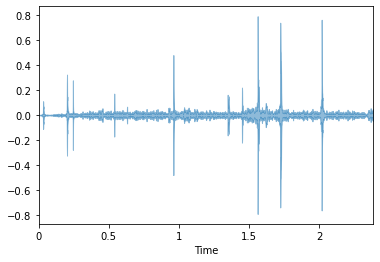

Datasets\Projeto\AudiosOriginais\CracklingFire\1-17150-A_0002 - descartar:False


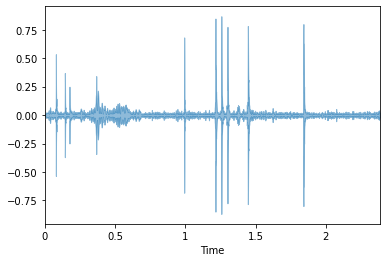

Datasets\Projeto\AudiosOriginais\CracklingFire\1-17150-A_0003 - descartar:False


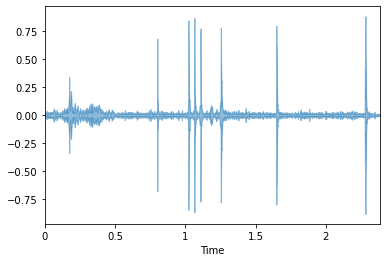

-------------------------------------------------------
[[0.01145545]
 [0.09796556]
 [0.34122354]]
Datasets\Projeto\AudiosOriginais\CracklingFire\1-17565-A_0001 - descartar:False


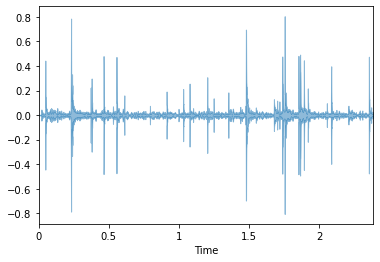

Datasets\Projeto\AudiosOriginais\CracklingFire\1-17565-A_0002 - descartar:False


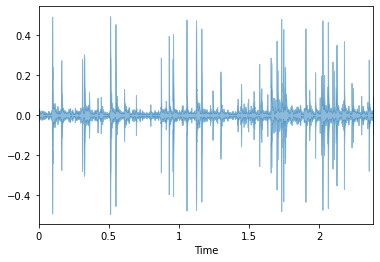

Datasets\Projeto\AudiosOriginais\CracklingFire\1-17565-A_0003 - descartar:False


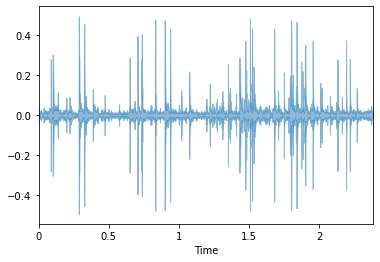

-------------------------------------------------------
[[0.00354968]
 [0.33946592]
 [0.07639161]]
Datasets\Projeto\AudiosOriginais\CracklingFire\1-17742-A_0001 - descartar:False


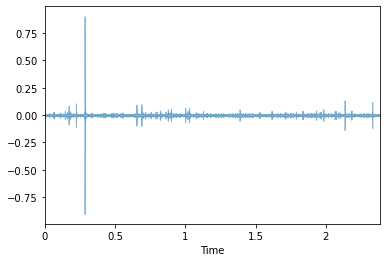

Datasets\Projeto\AudiosOriginais\CracklingFire\1-17742-A_0002 - descartar:False


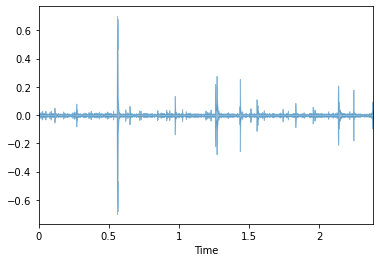

Datasets\Projeto\AudiosOriginais\CracklingFire\1-17742-A_0003 - descartar:False


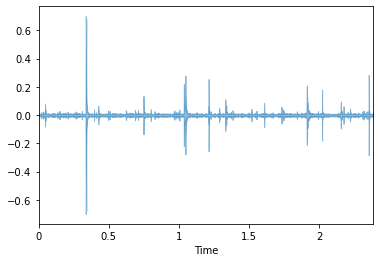

-------------------------------------------------------
[[0.01628314]
 [0.11066617]
 [0.0562482 ]]
Datasets\Projeto\AudiosOriginais\CracklingFire\1-17808-A_0001 - descartar:False


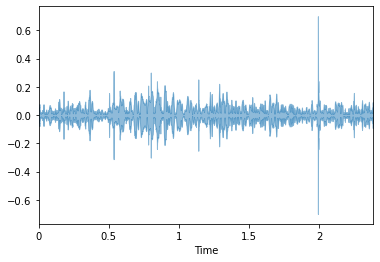

Datasets\Projeto\AudiosOriginais\CracklingFire\1-17808-A_0002 - descartar:False


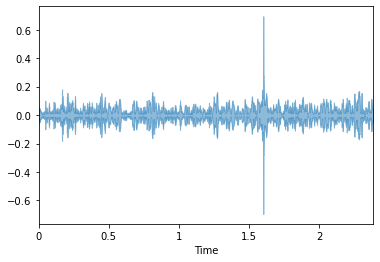

Datasets\Projeto\AudiosOriginais\CracklingFire\1-17808-A_0003 - descartar:False


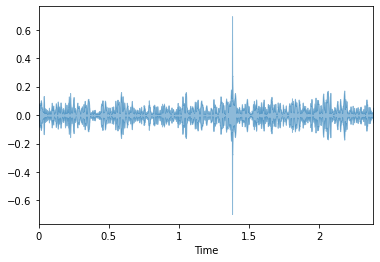

-------------------------------------------------------
[[0.11515912]
 [0.01302287]
 [0.04518681]]
Datasets\Projeto\AudiosOriginais\CracklingFire\1-17808-B_0001 - descartar:False


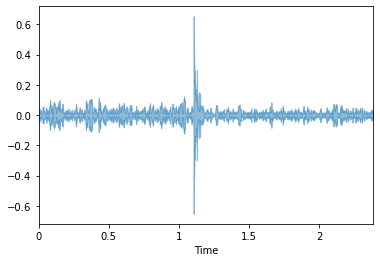

Datasets\Projeto\AudiosOriginais\CracklingFire\1-17808-B_0002 - descartar:False


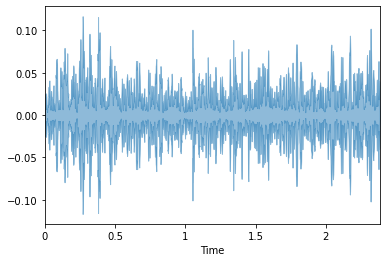

Datasets\Projeto\AudiosOriginais\CracklingFire\1-17808-B_0003 - descartar:False


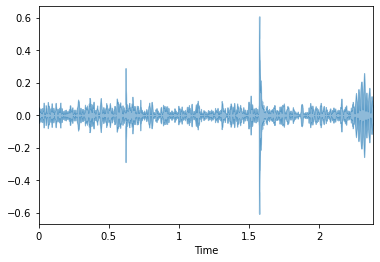

Datasets\Projeto\AudiosOriginais\CracklingFire\1-17808-B_0004 - descartar:False


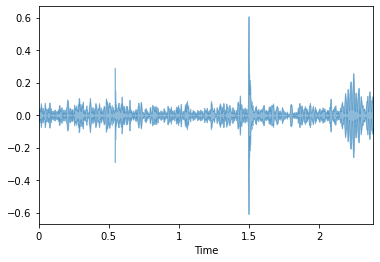

-------------------------------------------------------
[[0.0243669 ]
 [0.16039258]
 [0.07904611]]
Datasets\Projeto\AudiosOriginais\CracklingFire\1-4211-A_0001 - descartar:False


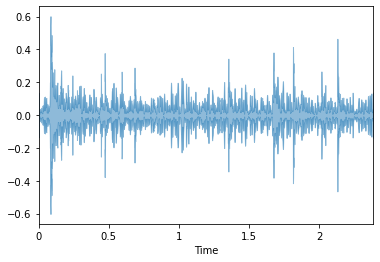

Datasets\Projeto\AudiosOriginais\CracklingFire\1-4211-A_0002 - descartar:False


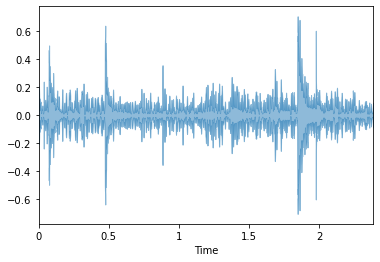

Datasets\Projeto\AudiosOriginais\CracklingFire\1-4211-A_0003 - descartar:False


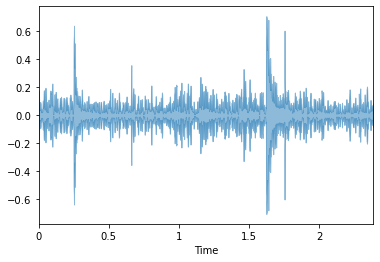

-------------------------------------------------------
[[0.0254292 ]
 [0.17406313]
 [0.08227773]]
Datasets\Projeto\AudiosOriginais\CracklingFire\1-46272-A_0001 - descartar:False


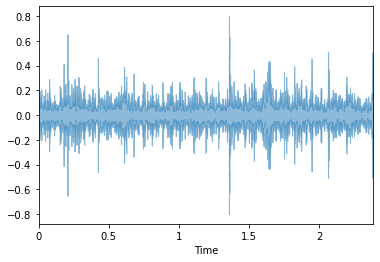

Datasets\Projeto\AudiosOriginais\CracklingFire\1-46272-A_0002 - descartar:False


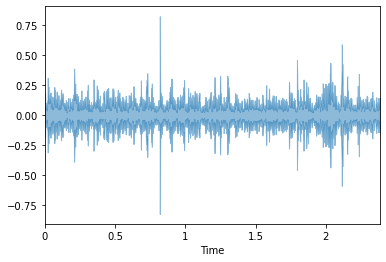

Datasets\Projeto\AudiosOriginais\CracklingFire\1-46272-A_0003 - descartar:False


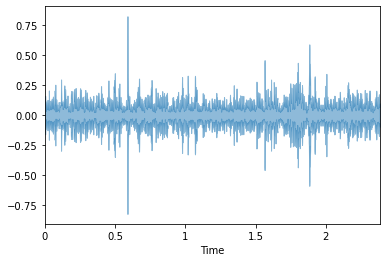

-------------------------------------------------------
[[0.0110595 ]
 [0.00294794]
 [0.77883303]]
Datasets\Projeto\AudiosOriginais\CracklingFire\1-7057-A_0001 - descartar:False


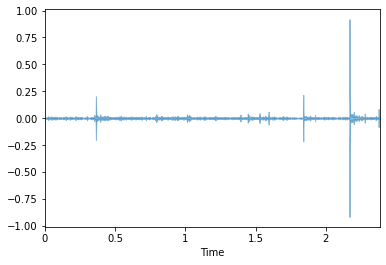

Datasets\Projeto\AudiosOriginais\CracklingFire\1-7057-A_0002 - descartar:True


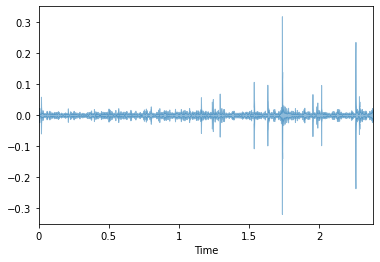

Datasets\Projeto\AudiosOriginais\CracklingFire\1-7057-A_0003 - descartar:True


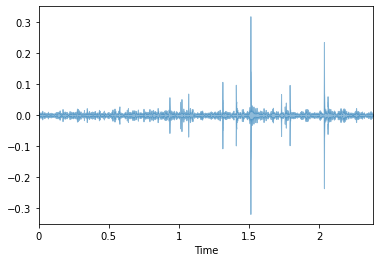

-------------------------------------------------------
[[0.00431229]
 [0.2664397 ]
 [0.04386058]]
Datasets\Projeto\AudiosOriginais\CracklingFire\2-18766-A_0001 - descartar:False


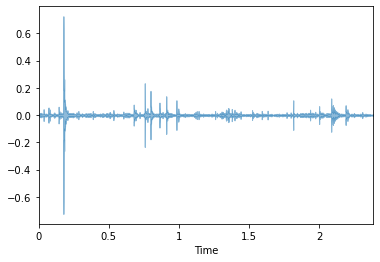

Datasets\Projeto\AudiosOriginais\CracklingFire\2-18766-A_0002 - descartar:False


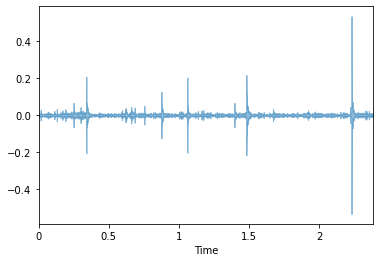

Datasets\Projeto\AudiosOriginais\CracklingFire\2-18766-A_0003 - descartar:False


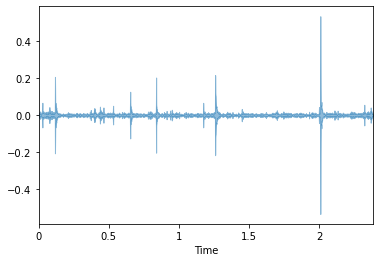

-------------------------------------------------------
[[0.00241539]
 [0.5860254 ]
 [0.15308096]]
Datasets\Projeto\AudiosOriginais\CracklingFire\2-18766-B_0001 - descartar:False


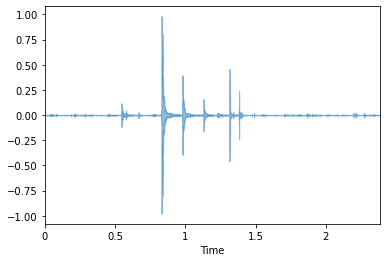

Datasets\Projeto\AudiosOriginais\CracklingFire\2-18766-B_0002 - descartar:True


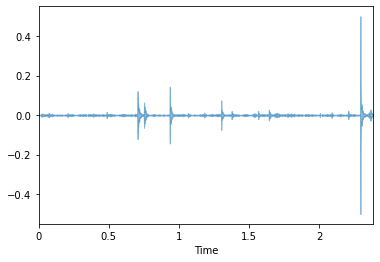

Datasets\Projeto\AudiosOriginais\CracklingFire\2-18766-B_0003 - descartar:True


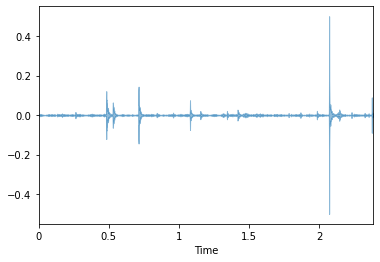

-------------------------------------------------------
[[0.00563107]
 [0.01987988]
 [0.22403078]]
Datasets\Projeto\AudiosOriginais\CracklingFire\2-28314-A_0001 - descartar:False


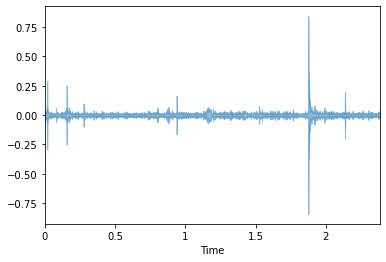

Datasets\Projeto\AudiosOriginais\CracklingFire\2-28314-A_0002 - descartar:True


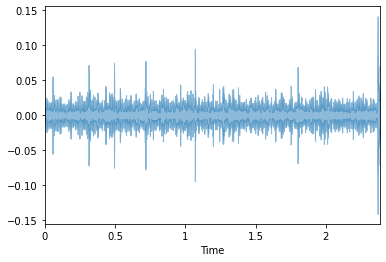

Datasets\Projeto\AudiosOriginais\CracklingFire\2-28314-A_0003 - descartar:True


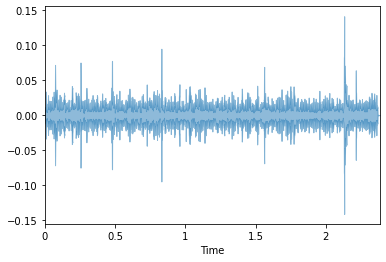

-------------------------------------------------------
[[0.00369592]
 [0.5501969 ]
 [0.15744747]]
Datasets\Projeto\AudiosOriginais\CracklingFire\2-28314-B_0001 - descartar:False


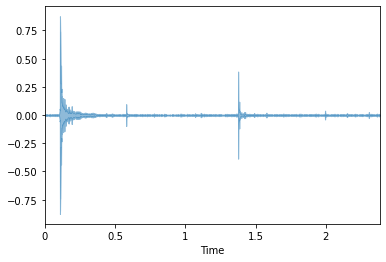

Datasets\Projeto\AudiosOriginais\CracklingFire\2-28314-B_0002 - descartar:False


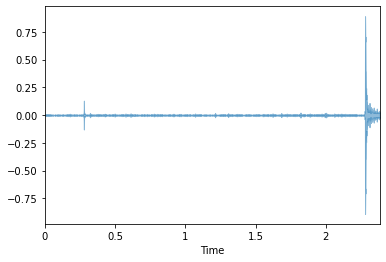

Datasets\Projeto\AudiosOriginais\CracklingFire\2-28314-B_0003 - descartar:False


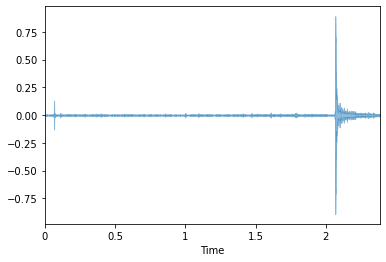

-------------------------------------------------------
[[0.1713726 ]
 [0.00821405]
 [0.0283901 ]]
Datasets\Projeto\AudiosOriginais\CracklingFire\2-30322-A_0001 - descartar:False


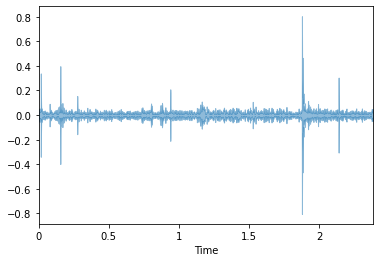

Datasets\Projeto\AudiosOriginais\CracklingFire\2-30322-A_0002 - descartar:False


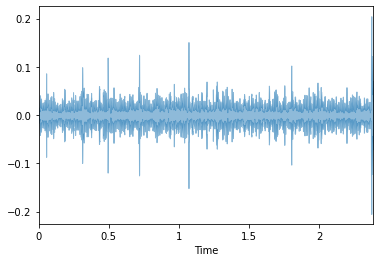

Datasets\Projeto\AudiosOriginais\CracklingFire\2-30322-A_0003 - descartar:False


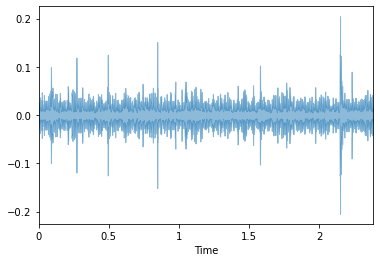

-------------------------------------------------------
[[0.01084615]
 [0.04182855]
 [0.27709576]]
Datasets\Projeto\AudiosOriginais\CracklingFire\2-30322-B_0001 - descartar:False


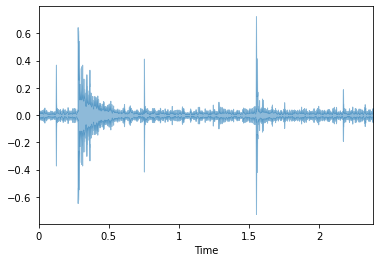

Datasets\Projeto\AudiosOriginais\CracklingFire\2-30322-B_0002 - descartar:False


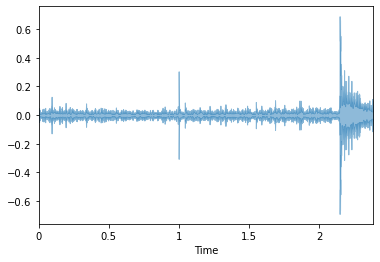

Datasets\Projeto\AudiosOriginais\CracklingFire\2-30322-B_0003 - descartar:False


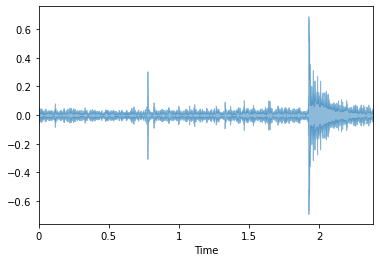

-------------------------------------------------------
[[0.14858226]
 [0.57615554]
 [0.01140532]]
Datasets\Projeto\AudiosOriginais\CracklingFire\2-61311-A_0001 - descartar:False


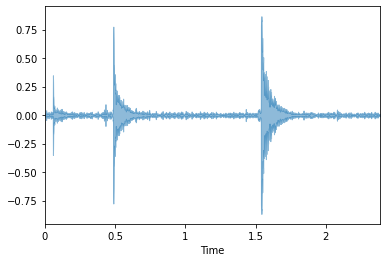

Datasets\Projeto\AudiosOriginais\CracklingFire\2-61311-A_0002 - descartar:True


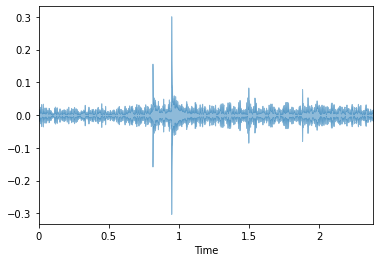

Datasets\Projeto\AudiosOriginais\CracklingFire\2-61311-A_0003 - descartar:True


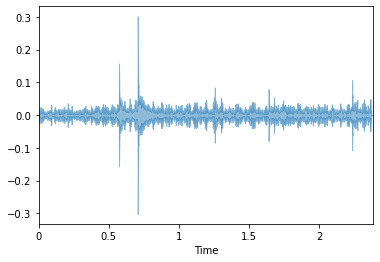

-------------------------------------------------------
[[0.0079183 ]
 [0.02889402]
 [0.15613563]]
Datasets\Projeto\AudiosOriginais\CracklingFire\2-65747-A_0001 - descartar:False


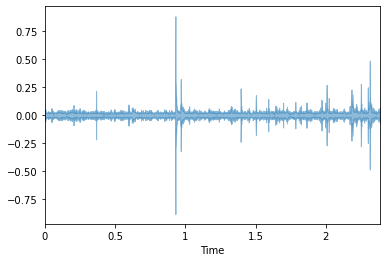

Datasets\Projeto\AudiosOriginais\CracklingFire\2-65747-A_0002 - descartar:False


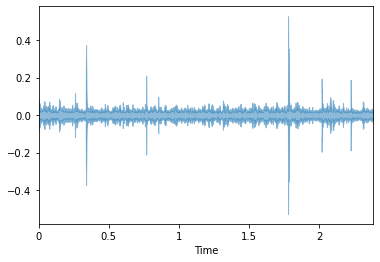

Datasets\Projeto\AudiosOriginais\CracklingFire\2-65747-A_0003 - descartar:False


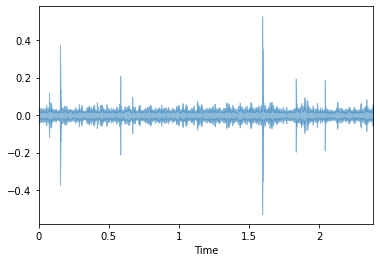

-------------------------------------------------------
[[0.00200324]
 [0.12342893]
 [0.63998413]]
Datasets\Projeto\AudiosOriginais\CracklingFire\3-104632-A_0001 - descartar:True


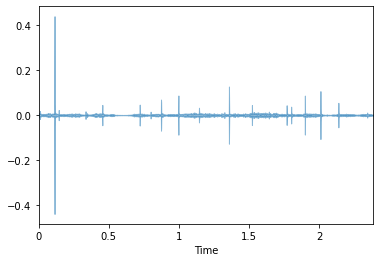

Datasets\Projeto\AudiosOriginais\CracklingFire\3-104632-A_0002 - descartar:True


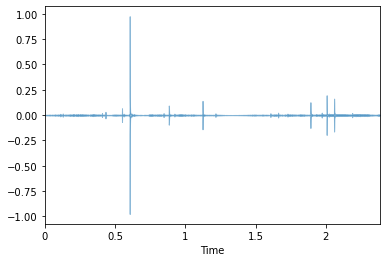

Datasets\Projeto\AudiosOriginais\CracklingFire\3-104632-A_0003 - descartar:True


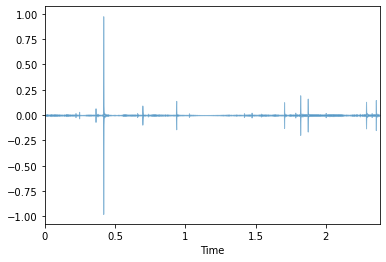

-------------------------------------------------------
[[0.00167799]
 [0.08637583]]
Datasets\Projeto\AudiosOriginais\CracklingFire\3-104958-A_0001 - descartar:False


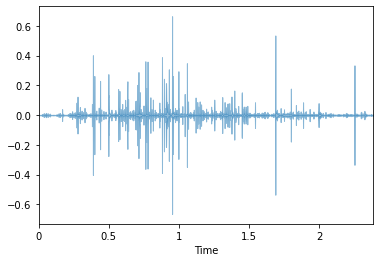

Datasets\Projeto\AudiosOriginais\CracklingFire\3-104958-A_0002 - descartar:False


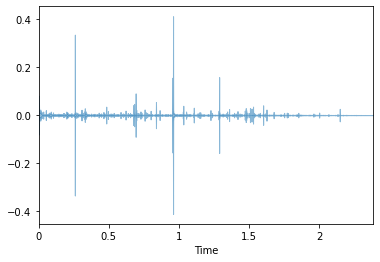

-------------------------------------------------------
[[0.00775922]
 [0.0269278 ]
 [0.06451687]]
Datasets\Projeto\AudiosOriginais\CracklingFire\3-120644-A_0001 - descartar:False


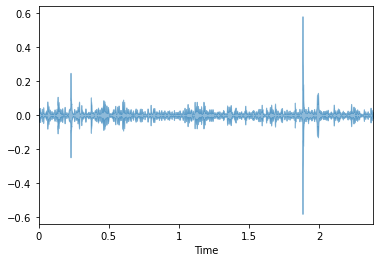

Datasets\Projeto\AudiosOriginais\CracklingFire\3-120644-A_0002 - descartar:False


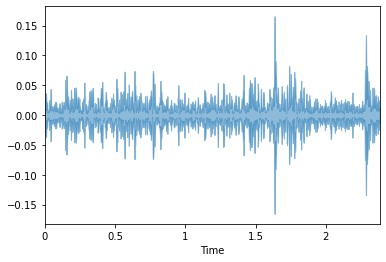

Datasets\Projeto\AudiosOriginais\CracklingFire\3-120644-A_0003 - descartar:False


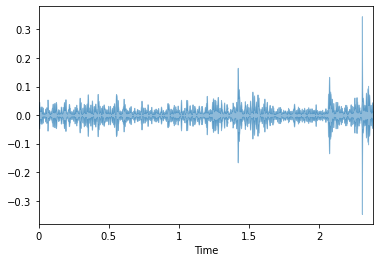

-------------------------------------------------------
[[0.0165333 ]
 [0.04535539]
 [0.00444796]]
Datasets\Projeto\AudiosOriginais\CracklingFire\3-145774-A_0001 - descartar:False


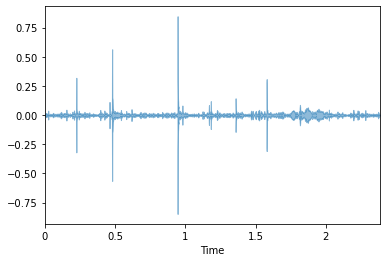

Datasets\Projeto\AudiosOriginais\CracklingFire\3-145774-A_0002 - descartar:False


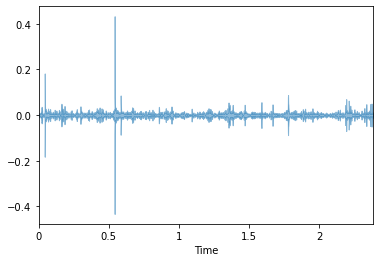

Datasets\Projeto\AudiosOriginais\CracklingFire\3-145774-A_0003 - descartar:False


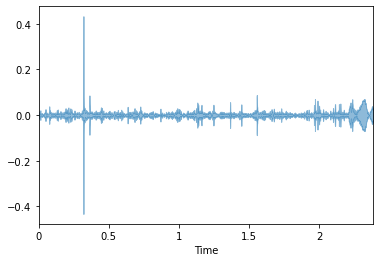

-------------------------------------------------------
[[0.00818712]
 [0.0270516 ]
 [0.05979972]]
Datasets\Projeto\AudiosOriginais\CracklingFire\3-147965-A_0001 - descartar:False


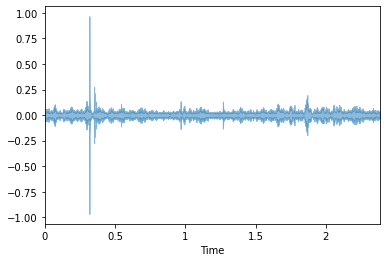

Datasets\Projeto\AudiosOriginais\CracklingFire\3-147965-A_0002 - descartar:False


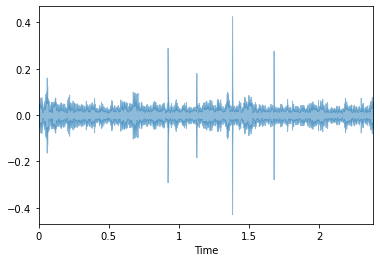

Datasets\Projeto\AudiosOriginais\CracklingFire\3-147965-A_0003 - descartar:False


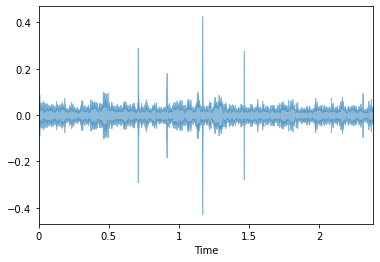

-------------------------------------------------------
Datasets\Projeto\AudiosOriginais\CracklingFire\3-157187-A_0001 - descartar:False


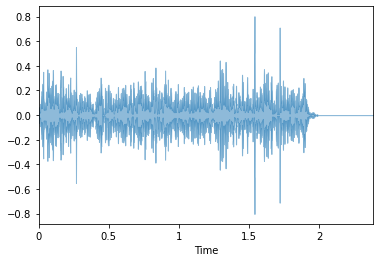

-------------------------------------------------------
[[0.00486787]
 [0.02548712]
 [0.4977374 ]]
Datasets\Projeto\AudiosOriginais\CracklingFire\3-158476-A_0001 - descartar:False


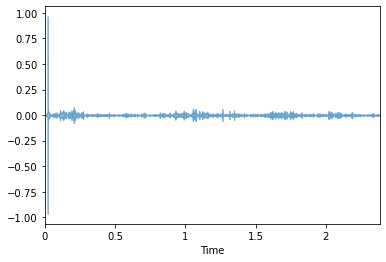

Datasets\Projeto\AudiosOriginais\CracklingFire\3-158476-A_0002 - descartar:False


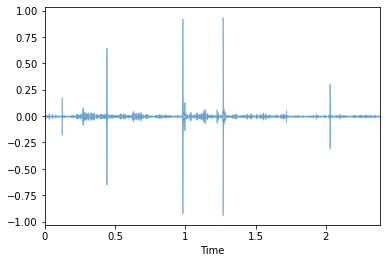

Datasets\Projeto\AudiosOriginais\CracklingFire\3-158476-A_0003 - descartar:False


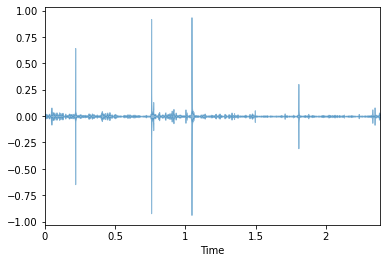

-------------------------------------------------------
[[0.0064806 ]
 [0.02395016]
 [0.3011264 ]]
Datasets\Projeto\AudiosOriginais\CracklingFire\3-65748-A_0001 - descartar:False


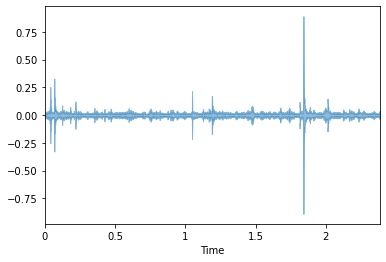

Datasets\Projeto\AudiosOriginais\CracklingFire\3-65748-A_0002 - descartar:True


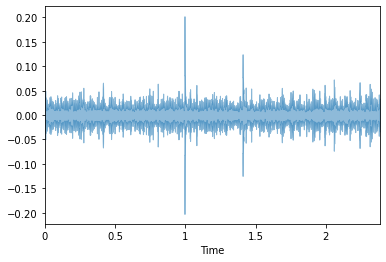

Datasets\Projeto\AudiosOriginais\CracklingFire\3-65748-A_0003 - descartar:True


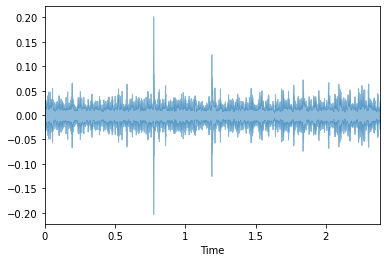

-------------------------------------------------------
[[0.15745538]
 [0.302346  ]
 [0.04961862]]
Datasets\Projeto\AudiosOriginais\CracklingFire\4-164661-A_0001 - descartar:False


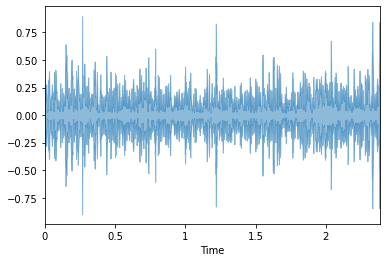

Datasets\Projeto\AudiosOriginais\CracklingFire\4-164661-A_0002 - descartar:False


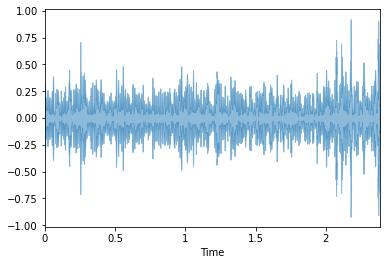

Datasets\Projeto\AudiosOriginais\CracklingFire\4-164661-A_0003 - descartar:False


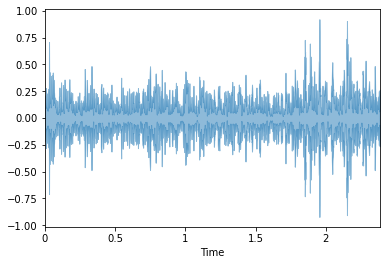

-------------------------------------------------------
[[0.02589838]
 [0.09197281]]
Datasets\Projeto\AudiosOriginais\CracklingFire\4-164661-B_0001 - descartar:False


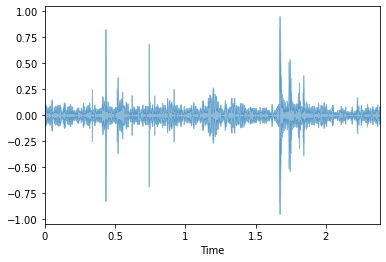

Datasets\Projeto\AudiosOriginais\CracklingFire\4-164661-B_0002 - descartar:False


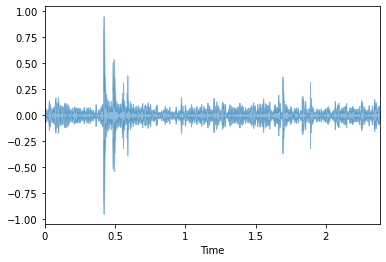

-------------------------------------------------------
[[0.06881757]
 [0.1260682 ]
 [0.02168893]]
Datasets\Projeto\AudiosOriginais\CracklingFire\4-170247-A_0001 - descartar:False


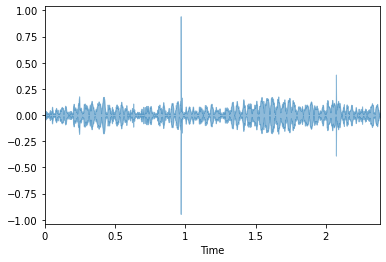

Datasets\Projeto\AudiosOriginais\CracklingFire\4-170247-A_0002 - descartar:False


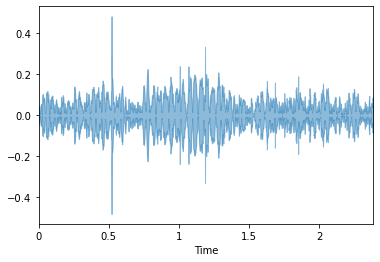

Datasets\Projeto\AudiosOriginais\CracklingFire\4-170247-A_0003 - descartar:False


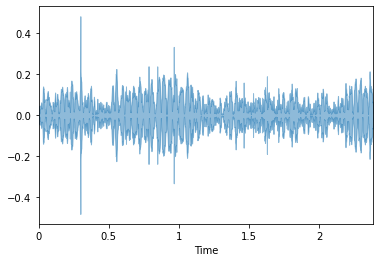

-------------------------------------------------------
[[0.10794243]
 [0.03437704]
 [0.19672912]]
Datasets\Projeto\AudiosOriginais\CracklingFire\4-170247-B_0001 - descartar:False


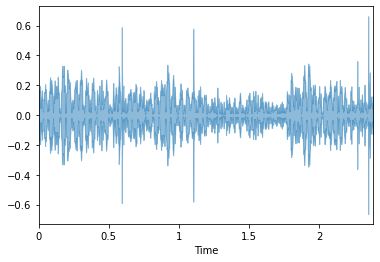

Datasets\Projeto\AudiosOriginais\CracklingFire\4-170247-B_0002 - descartar:False


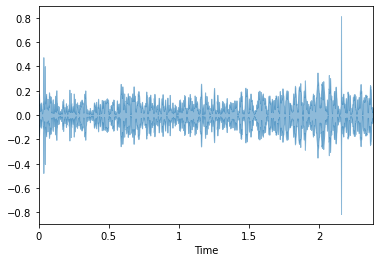

Datasets\Projeto\AudiosOriginais\CracklingFire\4-170247-B_0003 - descartar:False


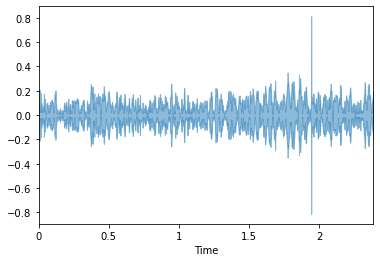

-------------------------------------------------------
[[0.14913557]
 [0.04692559]
 [0.2877045 ]]
Datasets\Projeto\AudiosOriginais\CracklingFire\4-171207-A_0001 - descartar:False


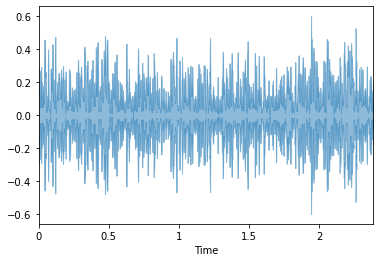

Datasets\Projeto\AudiosOriginais\CracklingFire\4-171207-A_0002 - descartar:False


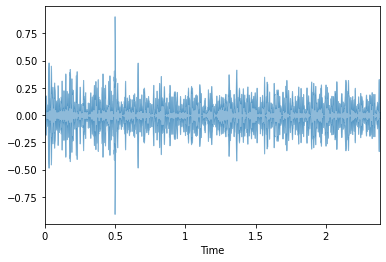

Datasets\Projeto\AudiosOriginais\CracklingFire\4-171207-A_0003 - descartar:False


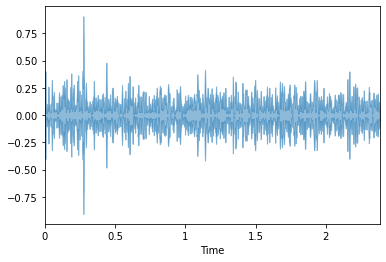

-------------------------------------------------------
[[0.0144152 ]
 [0.04715921]
 [0.09954274]]
Datasets\Projeto\AudiosOriginais\CracklingFire\4-181563-A_0001 - descartar:False


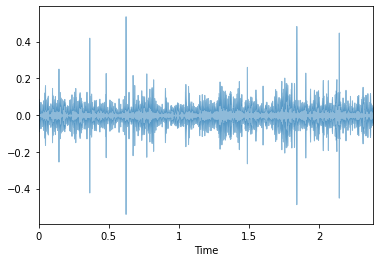

Datasets\Projeto\AudiosOriginais\CracklingFire\4-181563-A_0002 - descartar:False


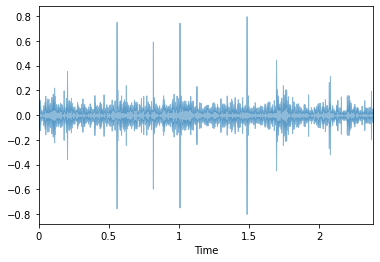

Datasets\Projeto\AudiosOriginais\CracklingFire\4-181563-A_0003 - descartar:False


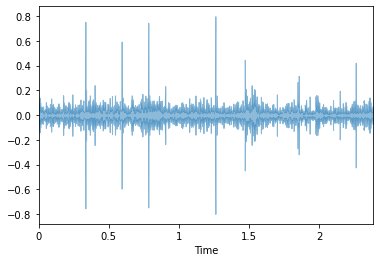

-------------------------------------------------------
[[0.00371152]
 [0.29945722]
 [0.01461072]]
Datasets\Projeto\AudiosOriginais\CracklingFire\4-182368-A_0001 - descartar:False


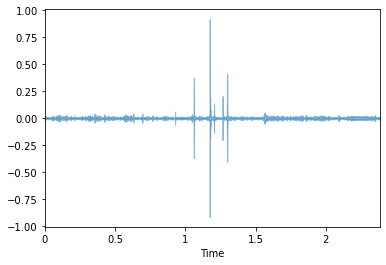

Datasets\Projeto\AudiosOriginais\CracklingFire\4-182368-A_0002 - descartar:True


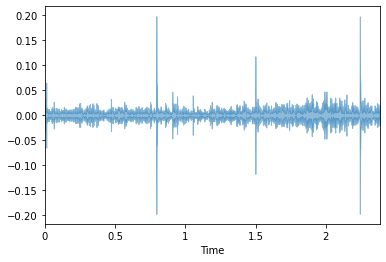

Datasets\Projeto\AudiosOriginais\CracklingFire\4-182368-A_0003 - descartar:True


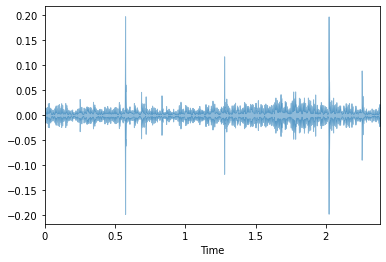

-------------------------------------------------------
[[0.00947291]
 [0.03174159]
 [0.0705198 ]]
Datasets\Projeto\AudiosOriginais\CracklingFire\4-182369-A_0001 - descartar:False


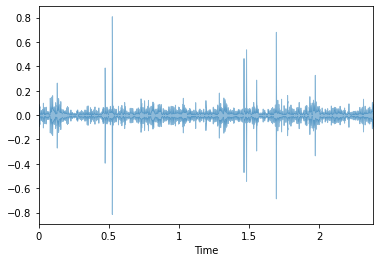

Datasets\Projeto\AudiosOriginais\CracklingFire\4-182369-A_0002 - descartar:False


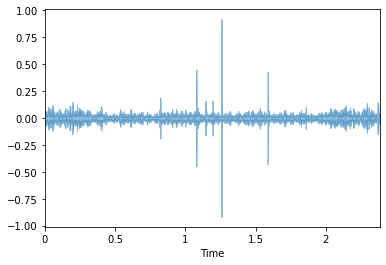

Datasets\Projeto\AudiosOriginais\CracklingFire\4-182369-A_0003 - descartar:False


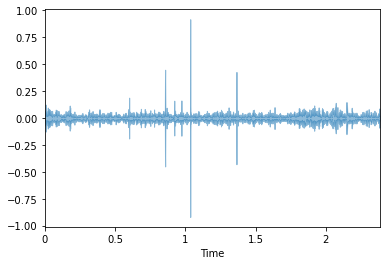

-------------------------------------------------------
[[0.4629232 ]
 [0.14934987]
 [0.8585887 ]]
Datasets\Projeto\AudiosOriginais\CracklingFire\5-186924-A_0001 - descartar:False


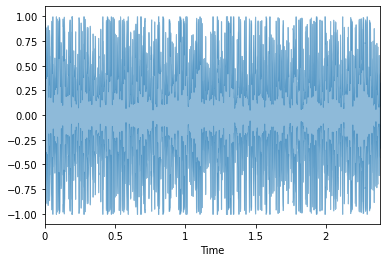

Datasets\Projeto\AudiosOriginais\CracklingFire\5-186924-A_0002 - descartar:False


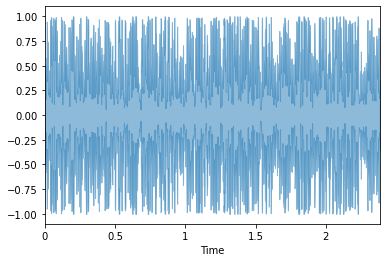

Datasets\Projeto\AudiosOriginais\CracklingFire\5-186924-A_0003 - descartar:False


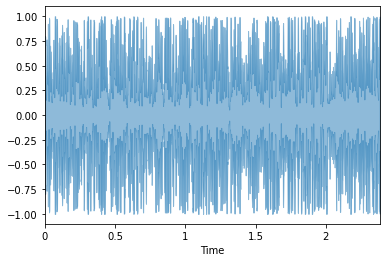

-------------------------------------------------------
[[0.04496474]
 [0.01427893]
 [0.09068666]]
Datasets\Projeto\AudiosOriginais\CracklingFire\5-189212-A_0001 - descartar:False


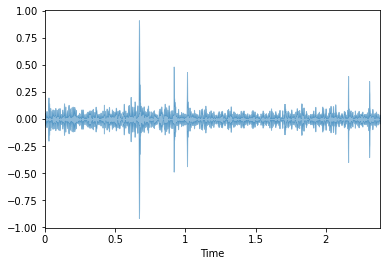

Datasets\Projeto\AudiosOriginais\CracklingFire\5-189212-A_0002 - descartar:False


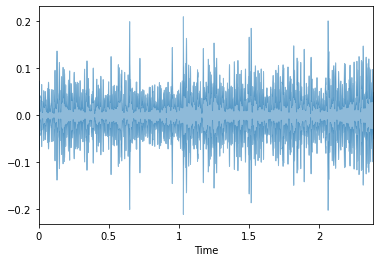

Datasets\Projeto\AudiosOriginais\CracklingFire\5-189212-A_0003 - descartar:False


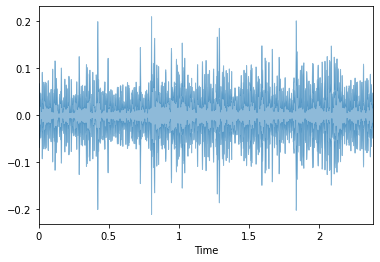

-------------------------------------------------------
[[0.00070005]
 [0.20516114]
 [0.04437157]]
Datasets\Projeto\AudiosOriginais\CracklingFire\5-189237-A_0001 - descartar:False


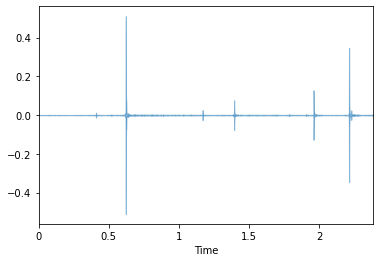

Datasets\Projeto\AudiosOriginais\CracklingFire\5-189237-A_0002 - descartar:False


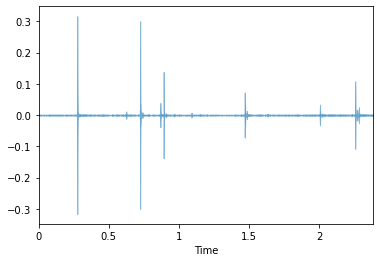

Datasets\Projeto\AudiosOriginais\CracklingFire\5-189237-A_0003 - descartar:False


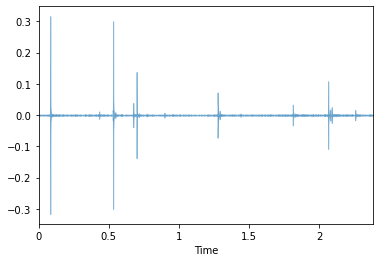

-------------------------------------------------------
[[0.00343473]
 [0.17624007]
 [0.03321607]]
Datasets\Projeto\AudiosOriginais\CracklingFire\5-193473-A_0001 - descartar:False


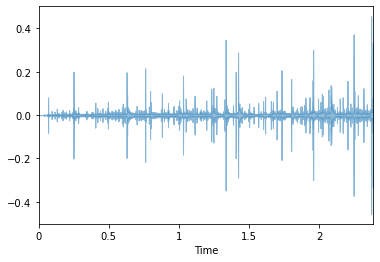

Datasets\Projeto\AudiosOriginais\CracklingFire\5-193473-A_0002 - descartar:False


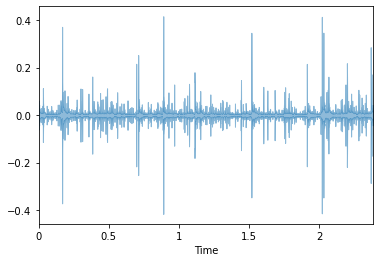

Datasets\Projeto\AudiosOriginais\CracklingFire\5-193473-A_0003 - descartar:False


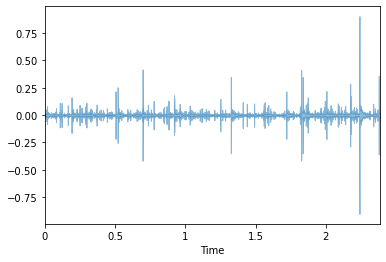

-------------------------------------------------------
[[0.00243352]
 [0.07600299]
 [0.42519432]]
Datasets\Projeto\AudiosOriginais\CracklingFire\5-193473-B_0001 - descartar:False


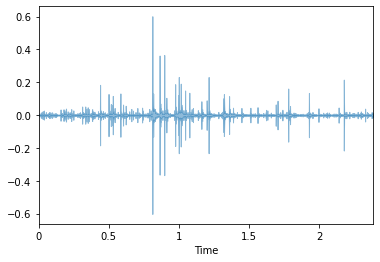

Datasets\Projeto\AudiosOriginais\CracklingFire\5-193473-B_0002 - descartar:False


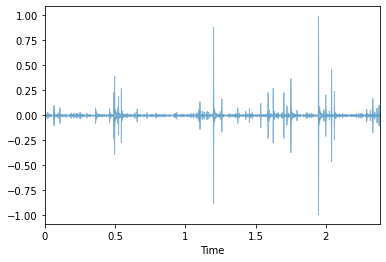

Datasets\Projeto\AudiosOriginais\CracklingFire\5-193473-B_0003 - descartar:False


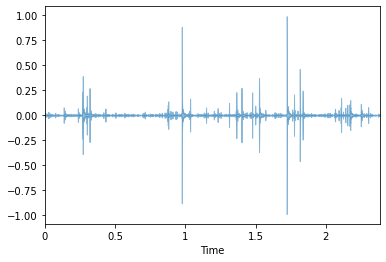

-------------------------------------------------------
[[0.17361182]
 [0.33973438]
 [0.05535205]]
Datasets\Projeto\AudiosOriginais\CracklingFire\5-213802-A_0001 - descartar:False


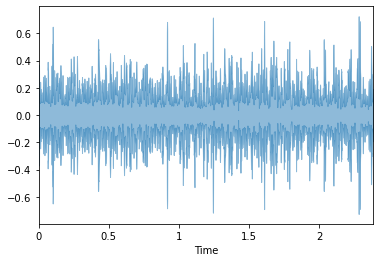

Datasets\Projeto\AudiosOriginais\CracklingFire\5-213802-A_0002 - descartar:False


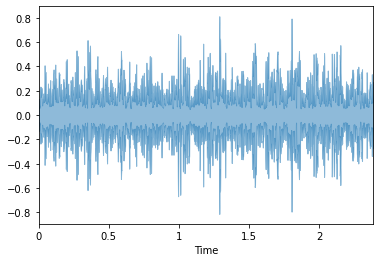

Datasets\Projeto\AudiosOriginais\CracklingFire\5-213802-A_0003 - descartar:False


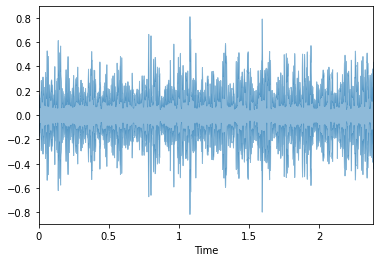

-------------------------------------------------------
[[0.01463693]
 [0.11087746]
 [0.04911233]]
Datasets\Projeto\AudiosOriginais\CracklingFire\5-215658-A_0001 - descartar:False


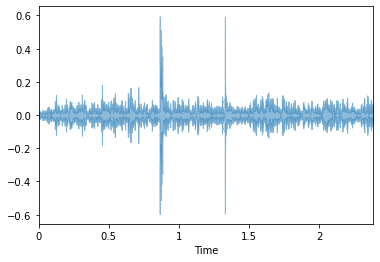

Datasets\Projeto\AudiosOriginais\CracklingFire\5-215658-A_0002 - descartar:False


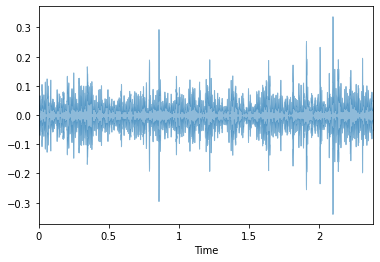

Datasets\Projeto\AudiosOriginais\CracklingFire\5-215658-A_0003 - descartar:False


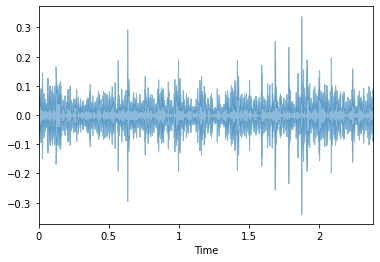

-------------------------------------------------------
[[0.0419983 ]
 [0.2772401 ]
 [0.13632852]]
Datasets\Projeto\AudiosOriginais\CracklingFire\5-215658-B_0001 - descartar:False


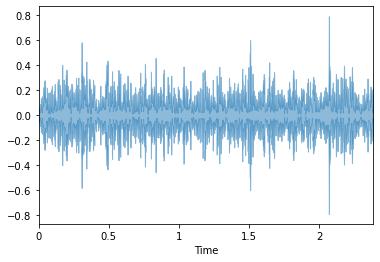

Datasets\Projeto\AudiosOriginais\CracklingFire\5-215658-B_0002 - descartar:False


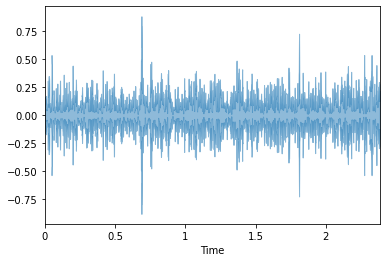

Datasets\Projeto\AudiosOriginais\CracklingFire\5-215658-B_0003 - descartar:False


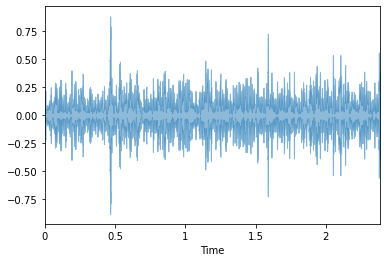

-------------------------------------------------------
[[0.04522554]
 [0.45810208]]
Datasets\Projeto\AudiosOriginais\GlassBreaking\1-20133-A_0001 - descartar:False


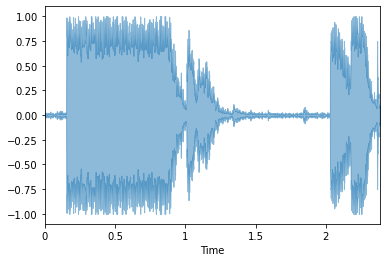

Datasets\Projeto\AudiosOriginais\GlassBreaking\1-20133-A_0002 - descartar:False


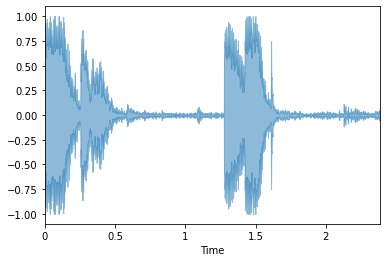

-------------------------------------------------------
[[0.03125275]
 [0.4653377 ]]
Datasets\Projeto\AudiosOriginais\GlassBreaking\1-84536-A_0001 - descartar:False


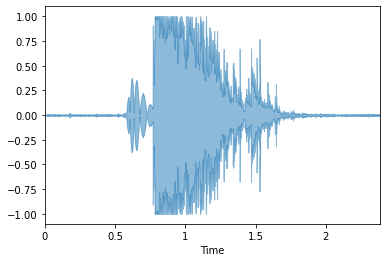

Datasets\Projeto\AudiosOriginais\GlassBreaking\1-84536-A_0002 - descartar:False


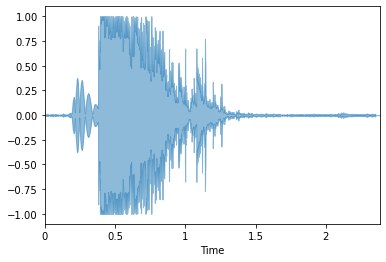

-------------------------------------------------------
Datasets\Projeto\AudiosOriginais\GlassBreaking\1-84704-A_0001 - descartar:False


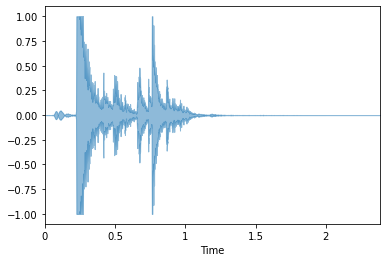

-------------------------------------------------------
Datasets\Projeto\AudiosOriginais\GlassBreaking\1-84705-A_0001 - descartar:False


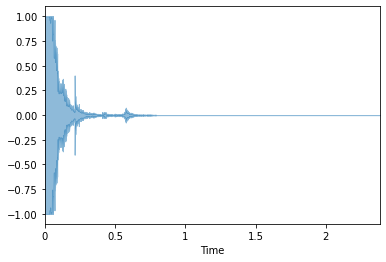

Datasets\Projeto\AudiosOriginais\GlassBreaking\1-84705-A_0002 - descartar:False


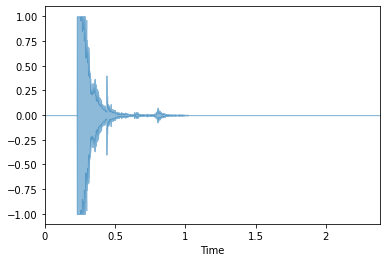

Datasets\Projeto\AudiosOriginais\GlassBreaking\1-84705-A_0003 - descartar:False


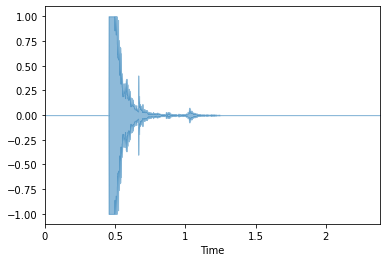

Datasets\Projeto\AudiosOriginais\GlassBreaking\1-84705-A_0004 - descartar:False


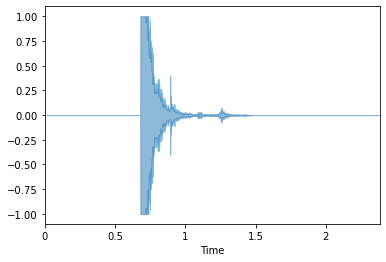

Datasets\Projeto\AudiosOriginais\GlassBreaking\1-84705-A_0005 - descartar:False


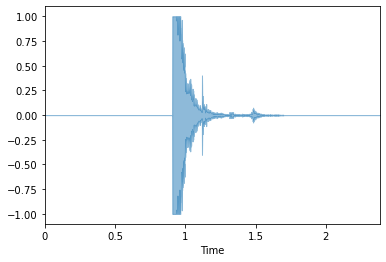

Datasets\Projeto\AudiosOriginais\GlassBreaking\1-84705-A_0006 - descartar:False


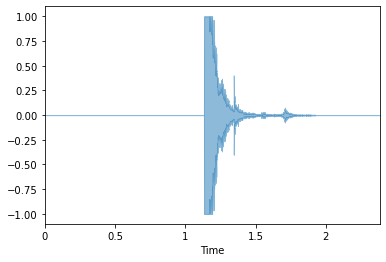

-------------------------------------------------------
[[0.01446337]
 [0.69815457]]
Datasets\Projeto\AudiosOriginais\GlassBreaking\1-85168-A_0001 - descartar:False


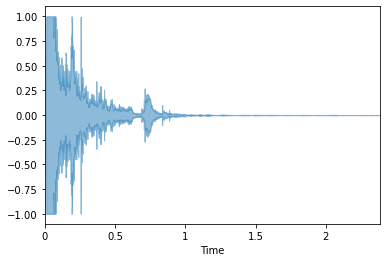

Datasets\Projeto\AudiosOriginais\GlassBreaking\1-85168-A_0002 - descartar:True


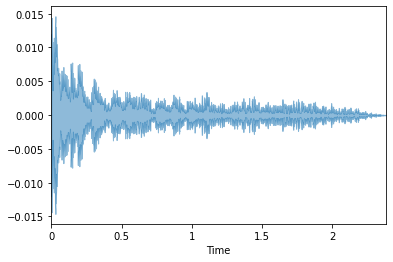

-------------------------------------------------------
Datasets\Projeto\AudiosOriginais\GlassBreaking\1-85184-A_0001 - descartar:False


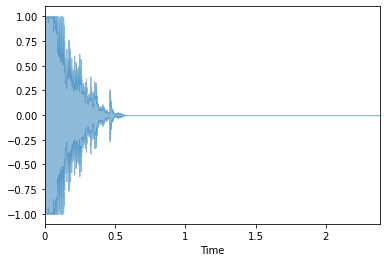

Datasets\Projeto\AudiosOriginais\GlassBreaking\1-85184-A_0002 - descartar:False


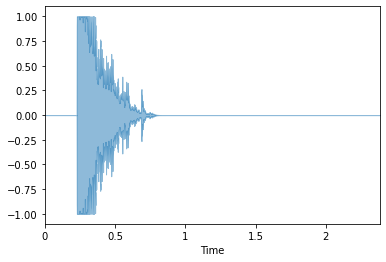

Datasets\Projeto\AudiosOriginais\GlassBreaking\1-85184-A_0003 - descartar:False


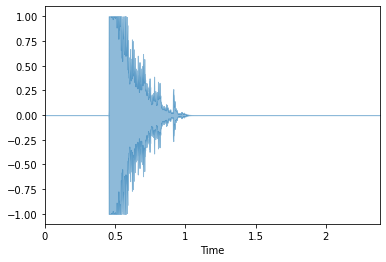

Datasets\Projeto\AudiosOriginais\GlassBreaking\1-85184-A_0004 - descartar:False


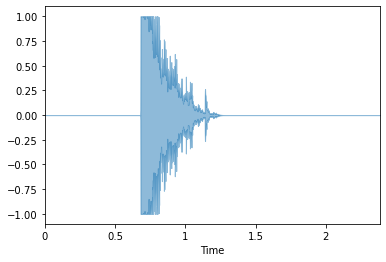

Datasets\Projeto\AudiosOriginais\GlassBreaking\1-85184-A_0005 - descartar:False


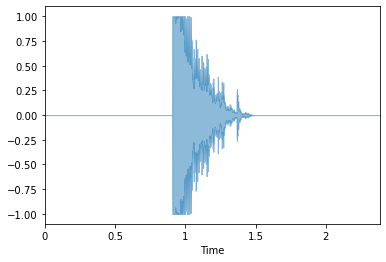

Datasets\Projeto\AudiosOriginais\GlassBreaking\1-85184-A_0006 - descartar:False


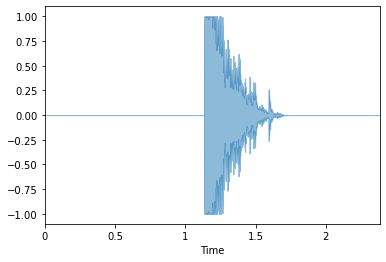

Datasets\Projeto\AudiosOriginais\GlassBreaking\1-85184-A_0007 - descartar:False


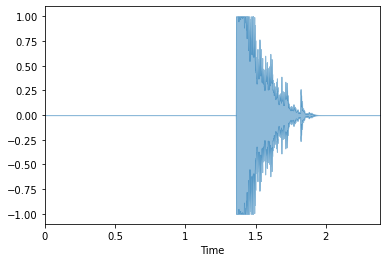

-------------------------------------------------------
[[0.00615728]
 [0.1239031 ]]
Datasets\Projeto\AudiosOriginais\GlassBreaking\1-88807-A_0001 - descartar:False


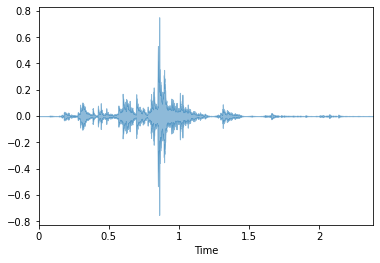

Datasets\Projeto\AudiosOriginais\GlassBreaking\1-88807-A_0002 - descartar:False


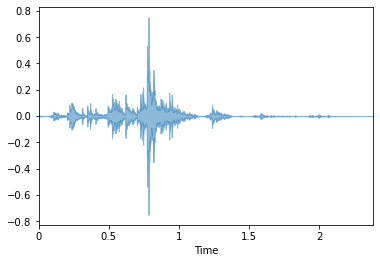

-------------------------------------------------------
Datasets\Projeto\AudiosOriginais\GlassBreaking\1-977-A_0001 - descartar:False


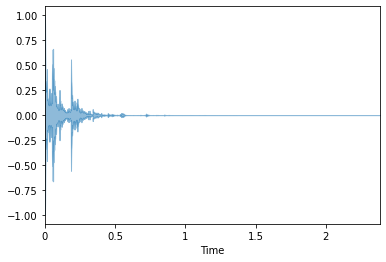

Datasets\Projeto\AudiosOriginais\GlassBreaking\1-977-A_0002 - descartar:False


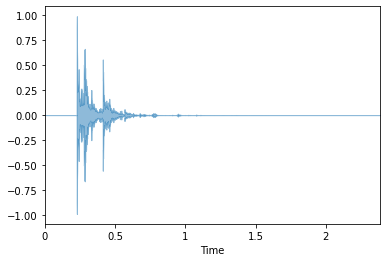

Datasets\Projeto\AudiosOriginais\GlassBreaking\1-977-A_0003 - descartar:False


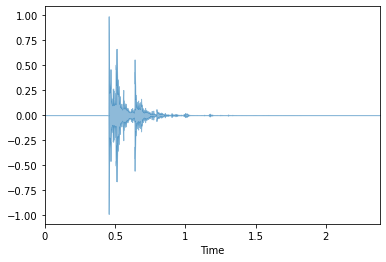

Datasets\Projeto\AudiosOriginais\GlassBreaking\1-977-A_0004 - descartar:False


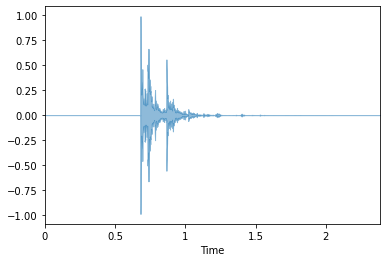

-------------------------------------------------------
[[0.38980702]
 [0.0114942 ]]
Datasets\Projeto\AudiosOriginais\GlassBreaking\2-106881-A_0001 - descartar:False


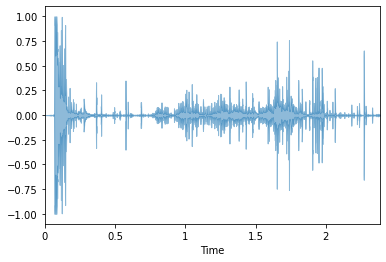

Datasets\Projeto\AudiosOriginais\GlassBreaking\2-106881-A_0002 - descartar:False


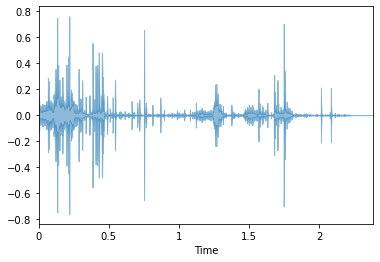

-------------------------------------------------------
[[0.01594642]
 [0.30253917]
 [0.12040162]]
Datasets\Projeto\AudiosOriginais\GlassBreaking\2-112213-A_0001 - descartar:False


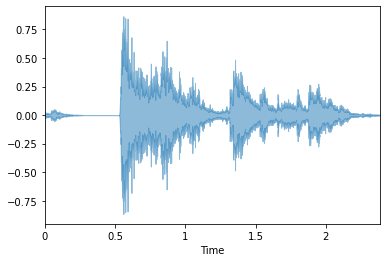

Datasets\Projeto\AudiosOriginais\GlassBreaking\2-112213-A_0002 - descartar:False


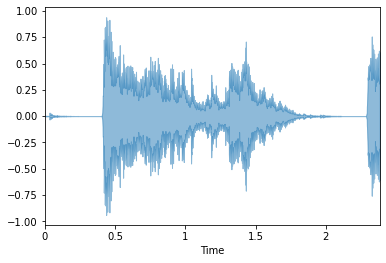

Datasets\Projeto\AudiosOriginais\GlassBreaking\2-112213-A_0003 - descartar:False


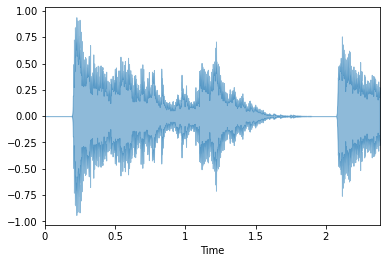

-------------------------------------------------------
[[0.02310534]
 [0.22298706]]
Datasets\Projeto\AudiosOriginais\GlassBreaking\2-112213-B_0001 - descartar:False


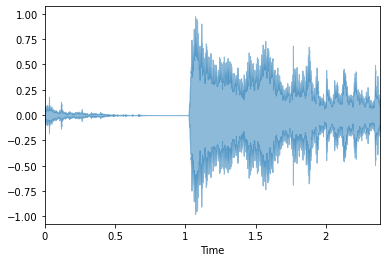

Datasets\Projeto\AudiosOriginais\GlassBreaking\2-112213-B_0002 - descartar:False


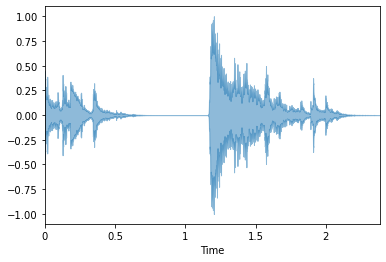

-------------------------------------------------------
Datasets\Projeto\AudiosOriginais\GlassBreaking\2-141563-A_0001 - descartar:False


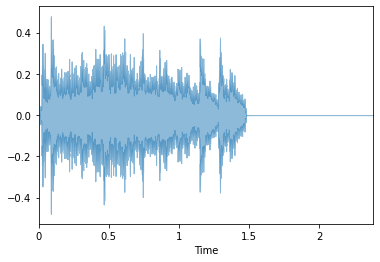

Datasets\Projeto\AudiosOriginais\GlassBreaking\2-141563-A_0002 - descartar:False


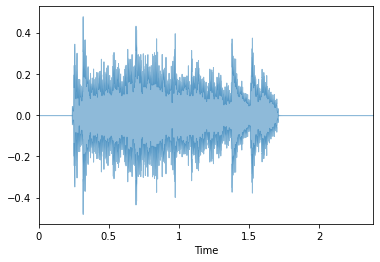

Datasets\Projeto\AudiosOriginais\GlassBreaking\2-141563-A_0003 - descartar:False


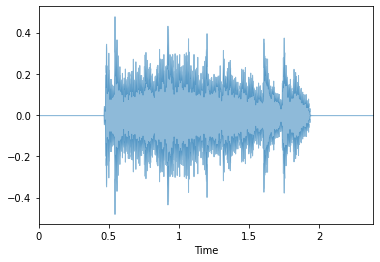

-------------------------------------------------------
[[0.00802602]
 [0.609978  ]
 [0.1200894 ]]
Datasets\Projeto\AudiosOriginais\GlassBreaking\2-173559-A_0001 - descartar:False


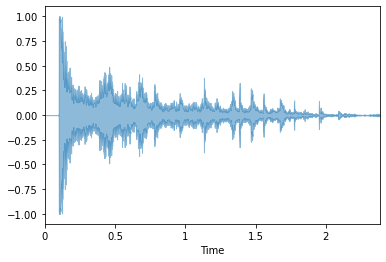

Datasets\Projeto\AudiosOriginais\GlassBreaking\2-173559-A_0002 - descartar:True


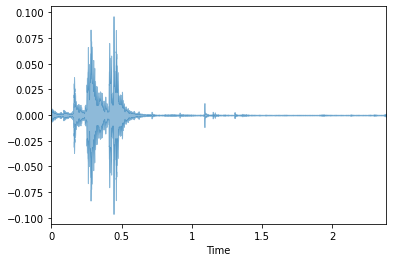

Datasets\Projeto\AudiosOriginais\GlassBreaking\2-173559-A_0003 - descartar:True


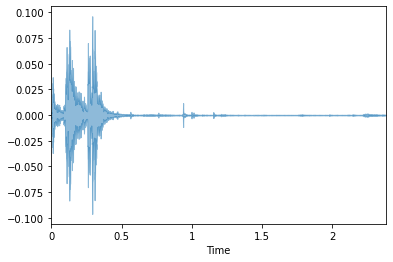

-------------------------------------------------------
[[0.01307068]
 [0.3018191 ]]
Datasets\Projeto\AudiosOriginais\GlassBreaking\2-173607-A_0001 - descartar:False


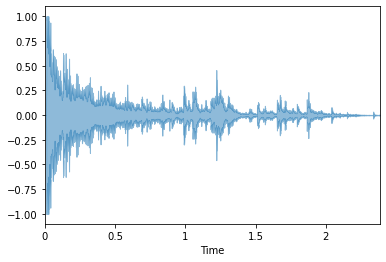

Datasets\Projeto\AudiosOriginais\GlassBreaking\2-173607-A_0002 - descartar:True


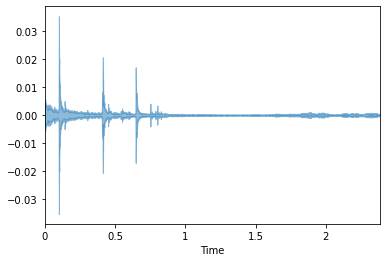

-------------------------------------------------------
[[0.18191814]
 [0.45784482]
 [0.01605866]]
Datasets\Projeto\AudiosOriginais\GlassBreaking\2-173618-A_0001 - descartar:False


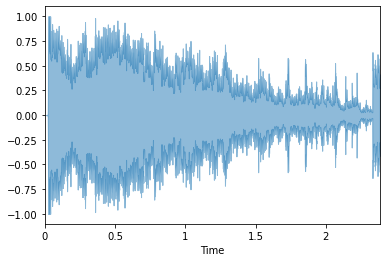

Datasets\Projeto\AudiosOriginais\GlassBreaking\2-173618-A_0002 - descartar:False


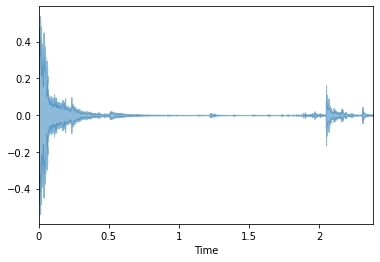

Datasets\Projeto\AudiosOriginais\GlassBreaking\2-173618-A_0003 - descartar:True


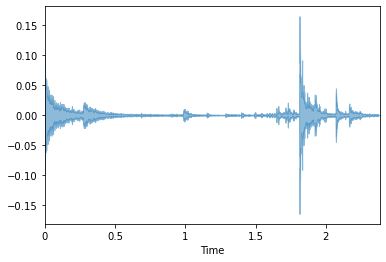

-------------------------------------------------------
[[0.01194002]
 [0.178482  ]]
Datasets\Projeto\AudiosOriginais\GlassBreaking\2-250710-A_0001 - descartar:False


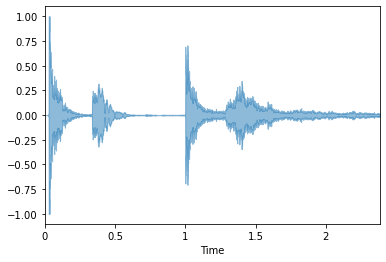

Datasets\Projeto\AudiosOriginais\GlassBreaking\2-250710-A_0002 - descartar:False


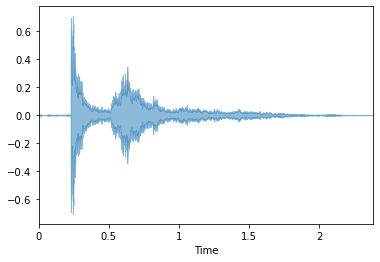

-------------------------------------------------------
Datasets\Projeto\AudiosOriginais\GlassBreaking\3-203371-A_0001 - descartar:False


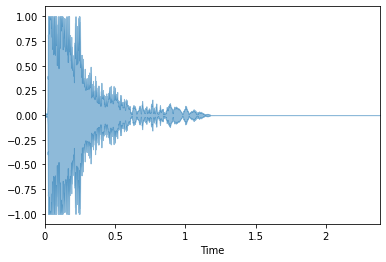

Datasets\Projeto\AudiosOriginais\GlassBreaking\3-203371-A_0002 - descartar:False


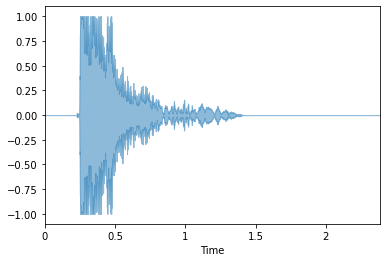

Datasets\Projeto\AudiosOriginais\GlassBreaking\3-203371-A_0003 - descartar:False


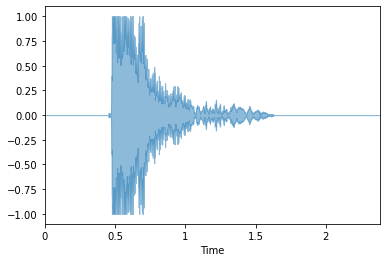

Datasets\Projeto\AudiosOriginais\GlassBreaking\3-203371-A_0004 - descartar:False


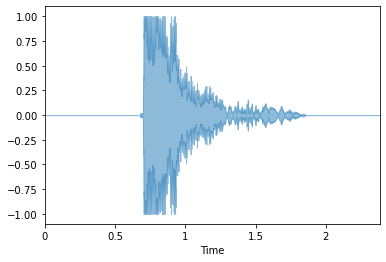

Datasets\Projeto\AudiosOriginais\GlassBreaking\3-203371-A_0005 - descartar:False


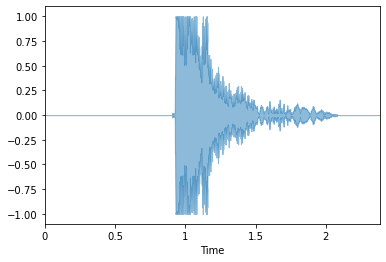

-------------------------------------------------------
Datasets\Projeto\AudiosOriginais\GlassBreaking\3-203373-A_0001 - descartar:False


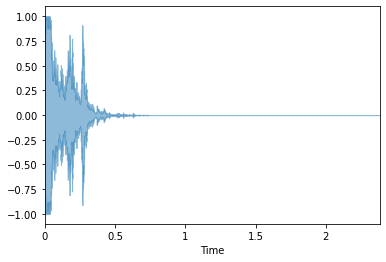

Datasets\Projeto\AudiosOriginais\GlassBreaking\3-203373-A_0002 - descartar:False


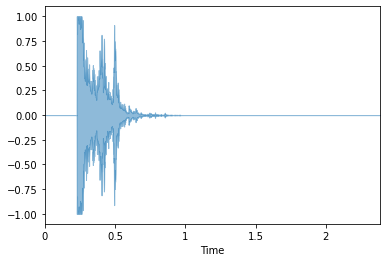

Datasets\Projeto\AudiosOriginais\GlassBreaking\3-203373-A_0003 - descartar:False


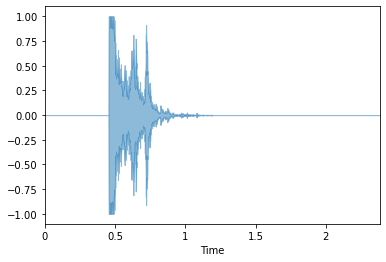

Datasets\Projeto\AudiosOriginais\GlassBreaking\3-203373-A_0004 - descartar:False


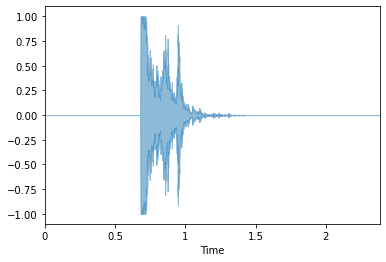

Datasets\Projeto\AudiosOriginais\GlassBreaking\3-203373-A_0005 - descartar:False


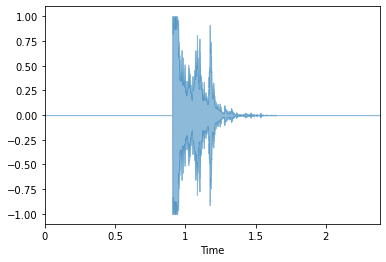

Datasets\Projeto\AudiosOriginais\GlassBreaking\3-203373-A_0006 - descartar:False


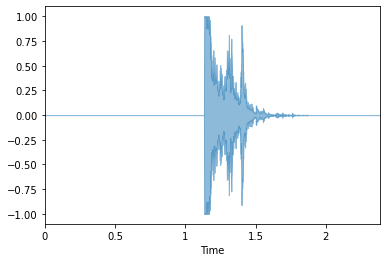

Datasets\Projeto\AudiosOriginais\GlassBreaking\3-203373-A_0007 - descartar:False


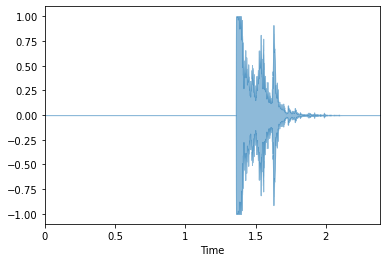

-------------------------------------------------------
Datasets\Projeto\AudiosOriginais\GlassBreaking\3-203374-A_0001 - descartar:False


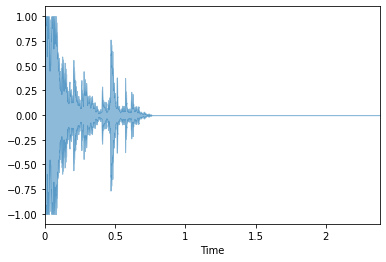

Datasets\Projeto\AudiosOriginais\GlassBreaking\3-203374-A_0002 - descartar:False


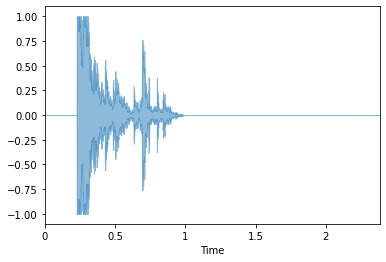

Datasets\Projeto\AudiosOriginais\GlassBreaking\3-203374-A_0003 - descartar:False


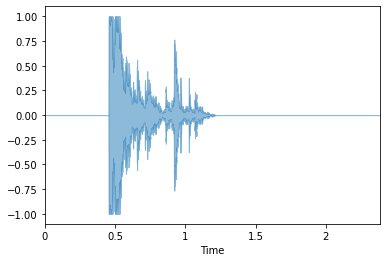

Datasets\Projeto\AudiosOriginais\GlassBreaking\3-203374-A_0004 - descartar:False


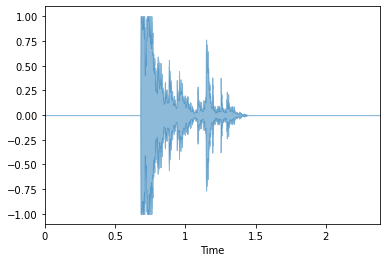

Datasets\Projeto\AudiosOriginais\GlassBreaking\3-203374-A_0005 - descartar:False


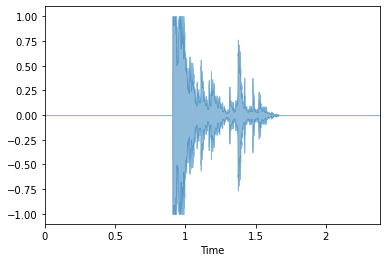

Datasets\Projeto\AudiosOriginais\GlassBreaking\3-203374-A_0006 - descartar:False


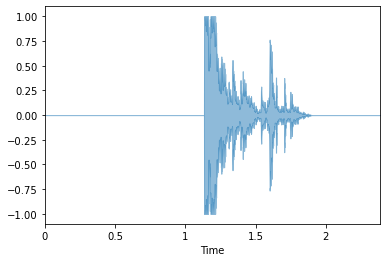

Datasets\Projeto\AudiosOriginais\GlassBreaking\3-203374-A_0007 - descartar:False


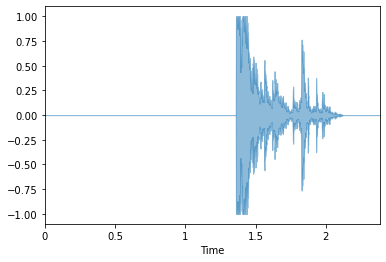

-------------------------------------------------------
Datasets\Projeto\AudiosOriginais\GlassBreaking\3-203375-A_0001 - descartar:False


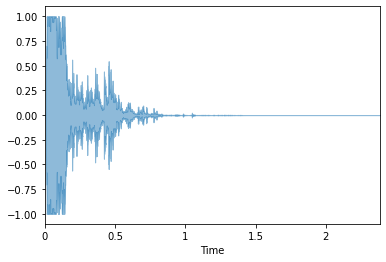

Datasets\Projeto\AudiosOriginais\GlassBreaking\3-203375-A_0002 - descartar:False


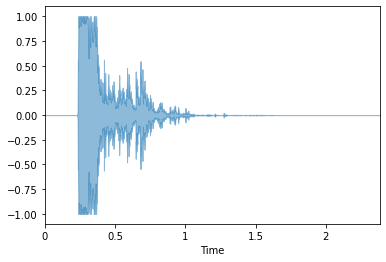

Datasets\Projeto\AudiosOriginais\GlassBreaking\3-203375-A_0003 - descartar:False


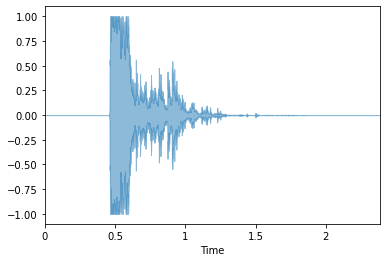

Datasets\Projeto\AudiosOriginais\GlassBreaking\3-203375-A_0004 - descartar:False


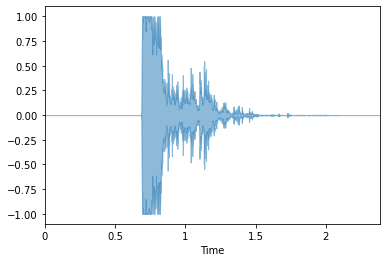

-------------------------------------------------------
Datasets\Projeto\AudiosOriginais\GlassBreaking\3-203377-A_0001 - descartar:False


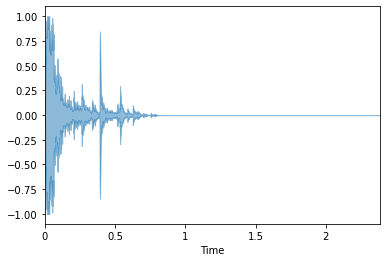

Datasets\Projeto\AudiosOriginais\GlassBreaking\3-203377-A_0002 - descartar:False


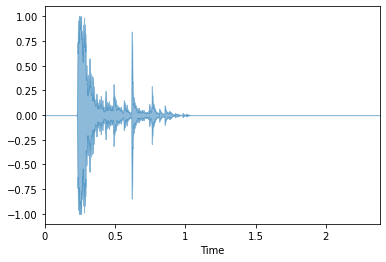

Datasets\Projeto\AudiosOriginais\GlassBreaking\3-203377-A_0003 - descartar:False


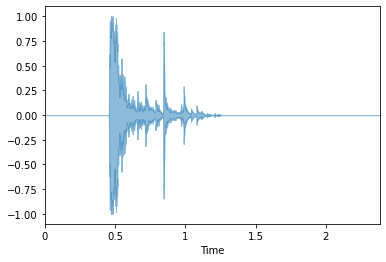

Datasets\Projeto\AudiosOriginais\GlassBreaking\3-203377-A_0004 - descartar:False


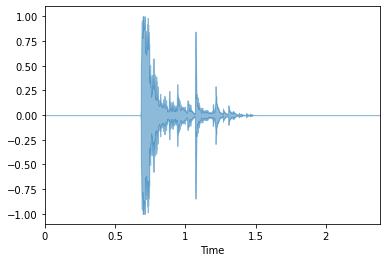

Datasets\Projeto\AudiosOriginais\GlassBreaking\3-203377-A_0005 - descartar:False


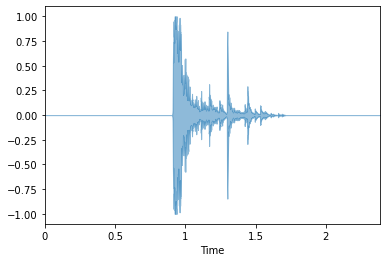

Datasets\Projeto\AudiosOriginais\GlassBreaking\3-203377-A_0006 - descartar:False


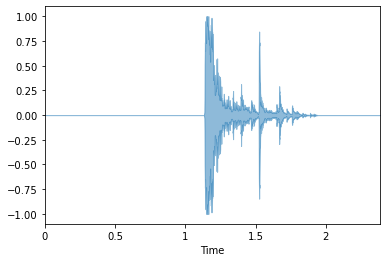

-------------------------------------------------------
Datasets\Projeto\AudiosOriginais\GlassBreaking\3-216280-A_0001 - descartar:False


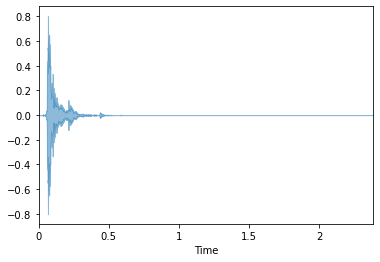

Datasets\Projeto\AudiosOriginais\GlassBreaking\3-216280-A_0002 - descartar:False


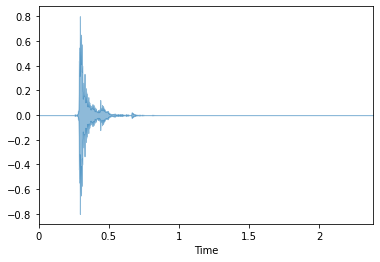

Datasets\Projeto\AudiosOriginais\GlassBreaking\3-216280-A_0003 - descartar:False


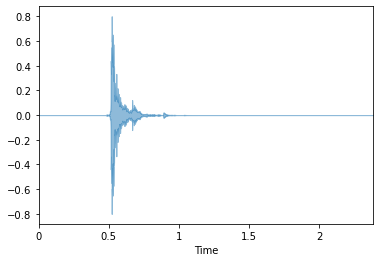

Datasets\Projeto\AudiosOriginais\GlassBreaking\3-216280-A_0004 - descartar:False


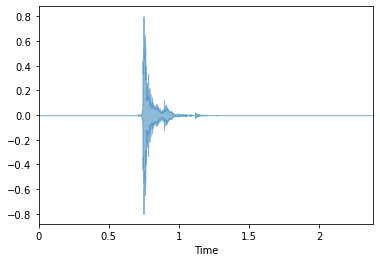

Datasets\Projeto\AudiosOriginais\GlassBreaking\3-216280-A_0005 - descartar:False


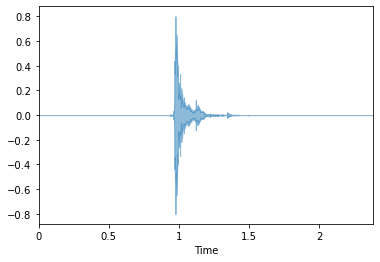

Datasets\Projeto\AudiosOriginais\GlassBreaking\3-216280-A_0006 - descartar:False


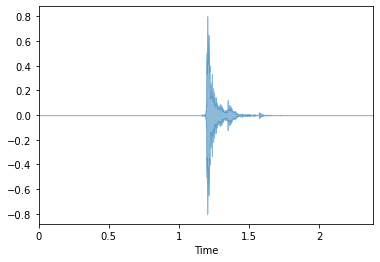

Datasets\Projeto\AudiosOriginais\GlassBreaking\3-216280-A_0007 - descartar:False


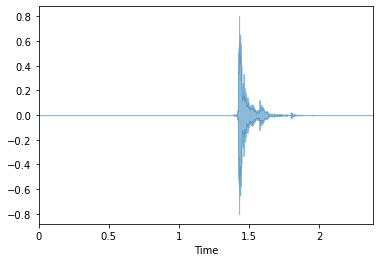

-------------------------------------------------------
Datasets\Projeto\AudiosOriginais\GlassBreaking\3-216281-A_0001 - descartar:False


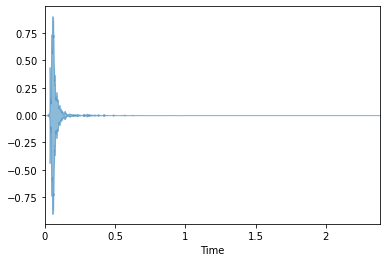

Datasets\Projeto\AudiosOriginais\GlassBreaking\3-216281-A_0002 - descartar:False


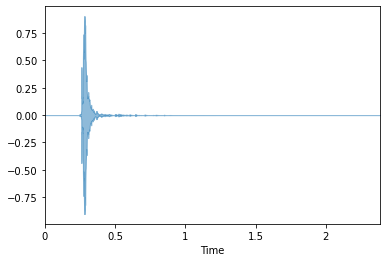

Datasets\Projeto\AudiosOriginais\GlassBreaking\3-216281-A_0003 - descartar:False


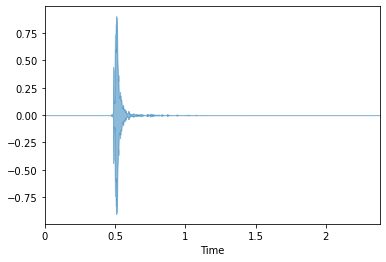

Datasets\Projeto\AudiosOriginais\GlassBreaking\3-216281-A_0004 - descartar:False


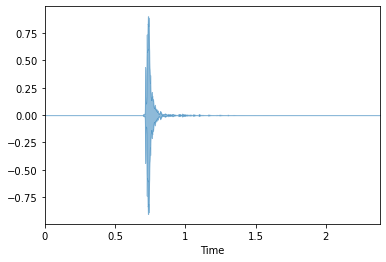

Datasets\Projeto\AudiosOriginais\GlassBreaking\3-216281-A_0005 - descartar:False


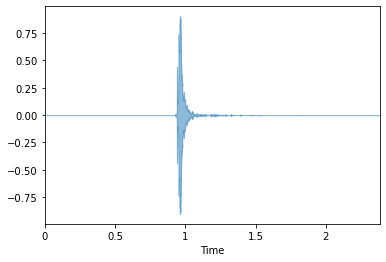

Datasets\Projeto\AudiosOriginais\GlassBreaking\3-216281-A_0006 - descartar:False


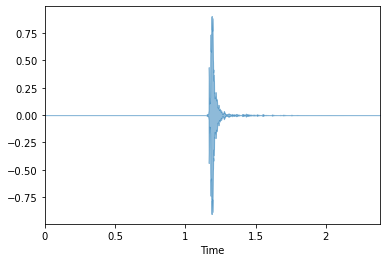

-------------------------------------------------------
Datasets\Projeto\AudiosOriginais\GlassBreaking\3-216284-A_0001 - descartar:False


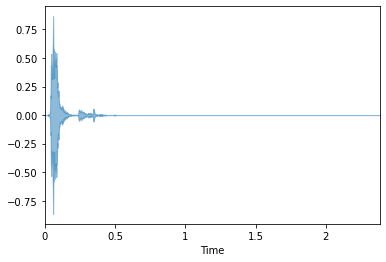

Datasets\Projeto\AudiosOriginais\GlassBreaking\3-216284-A_0002 - descartar:False


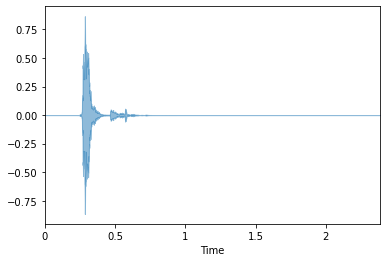

Datasets\Projeto\AudiosOriginais\GlassBreaking\3-216284-A_0003 - descartar:False


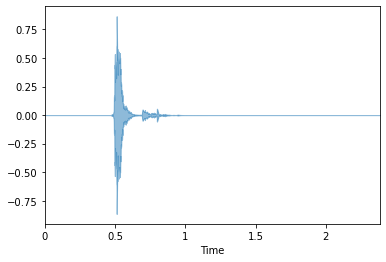

Datasets\Projeto\AudiosOriginais\GlassBreaking\3-216284-A_0004 - descartar:False


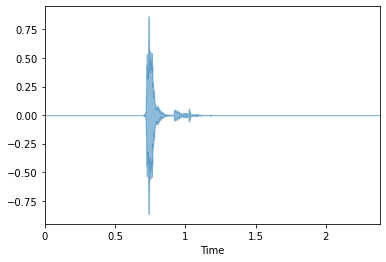

Datasets\Projeto\AudiosOriginais\GlassBreaking\3-216284-A_0005 - descartar:False


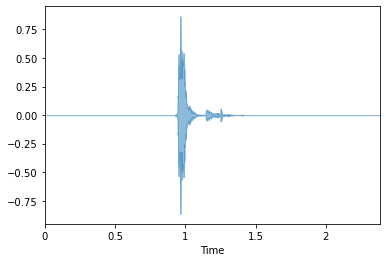

Datasets\Projeto\AudiosOriginais\GlassBreaking\3-216284-A_0006 - descartar:False


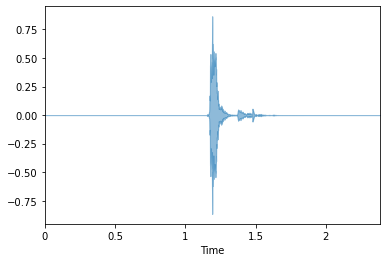

Datasets\Projeto\AudiosOriginais\GlassBreaking\3-216284-A_0007 - descartar:False


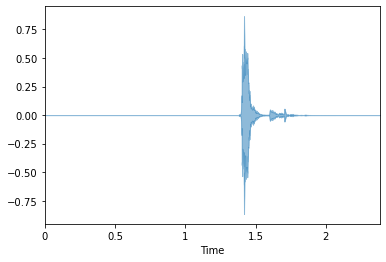

-------------------------------------------------------
Datasets\Projeto\AudiosOriginais\GlassBreaking\4-204115-A_0001 - descartar:False


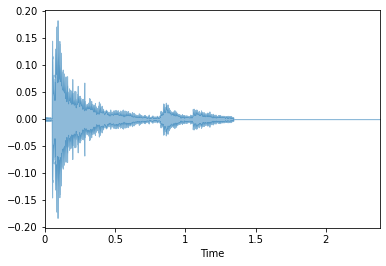

Datasets\Projeto\AudiosOriginais\GlassBreaking\4-204115-A_0002 - descartar:False


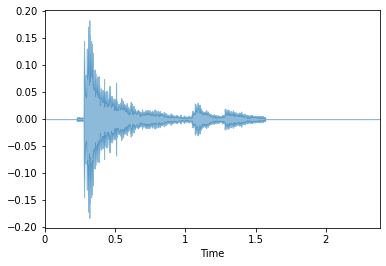

Datasets\Projeto\AudiosOriginais\GlassBreaking\4-204115-A_0003 - descartar:False


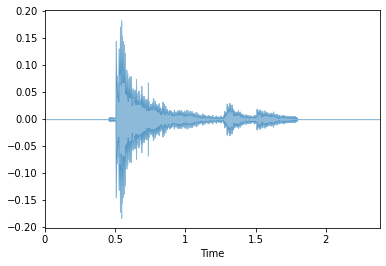

Datasets\Projeto\AudiosOriginais\GlassBreaking\4-204115-A_0004 - descartar:False


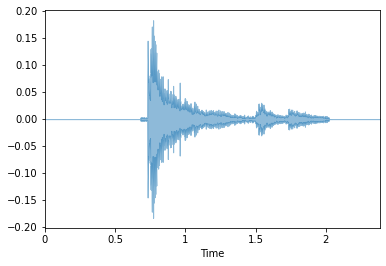

-------------------------------------------------------
Datasets\Projeto\AudiosOriginais\GlassBreaking\4-204119-A_0001 - descartar:False


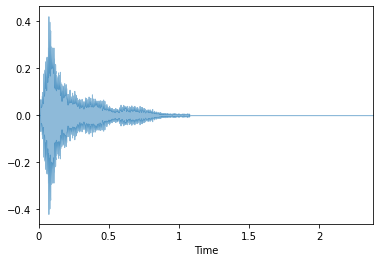

Datasets\Projeto\AudiosOriginais\GlassBreaking\4-204119-A_0002 - descartar:False


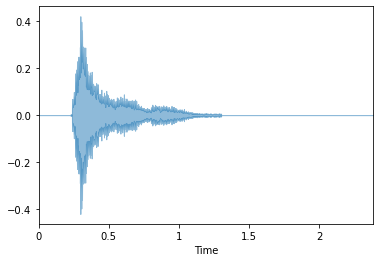

Datasets\Projeto\AudiosOriginais\GlassBreaking\4-204119-A_0003 - descartar:False


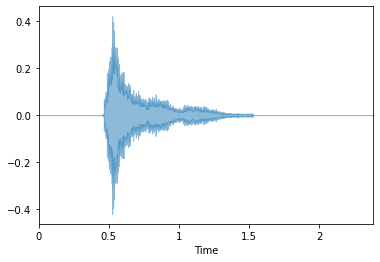

Datasets\Projeto\AudiosOriginais\GlassBreaking\4-204119-A_0004 - descartar:False


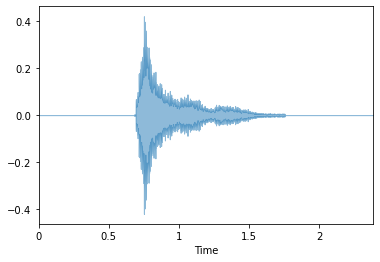

Datasets\Projeto\AudiosOriginais\GlassBreaking\4-204119-A_0005 - descartar:False


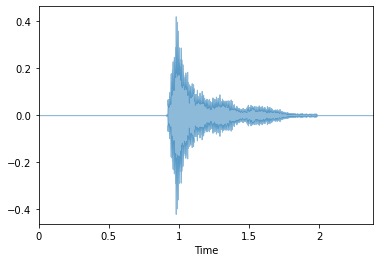

-------------------------------------------------------
Datasets\Projeto\AudiosOriginais\GlassBreaking\4-204121-A_0001 - descartar:False


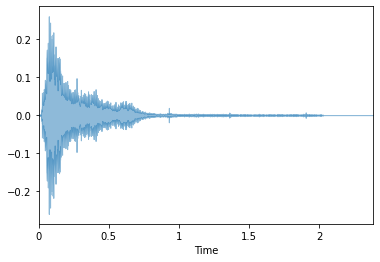

-------------------------------------------------------
Datasets\Projeto\AudiosOriginais\GlassBreaking\4-204123-A_0001 - descartar:False


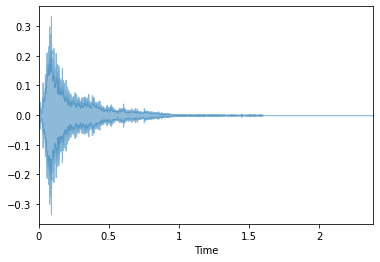

Datasets\Projeto\AudiosOriginais\GlassBreaking\4-204123-A_0002 - descartar:False


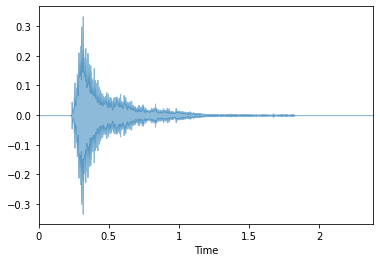

Datasets\Projeto\AudiosOriginais\GlassBreaking\4-204123-A_0003 - descartar:False


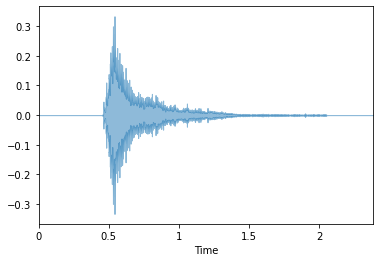

-------------------------------------------------------
[[0.40166852]
 [0.05213997]
 [0.9085915 ]]
Datasets\Projeto\AudiosOriginais\GlassBreaking\4-204777-A_0001 - descartar:False


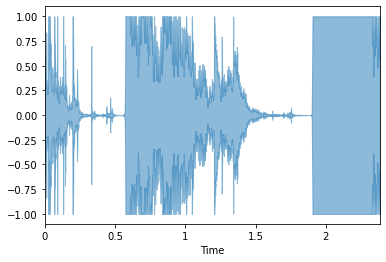

Datasets\Projeto\AudiosOriginais\GlassBreaking\4-204777-A_0002 - descartar:False


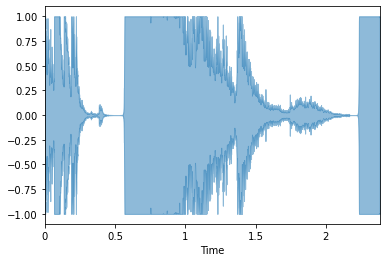

Datasets\Projeto\AudiosOriginais\GlassBreaking\4-204777-A_0003 - descartar:False


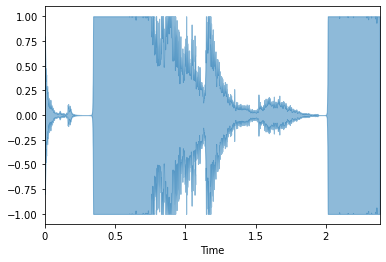

-------------------------------------------------------
[[0.03907147]
 [0.4086978 ]
 [0.92314184]]
Datasets\Projeto\AudiosOriginais\GlassBreaking\4-204777-B_0001 - descartar:False


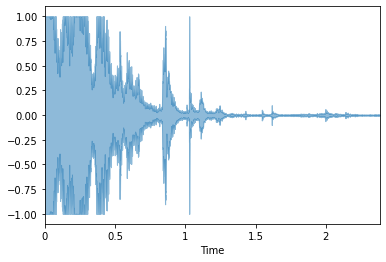

Datasets\Projeto\AudiosOriginais\GlassBreaking\4-204777-B_0002 - descartar:False


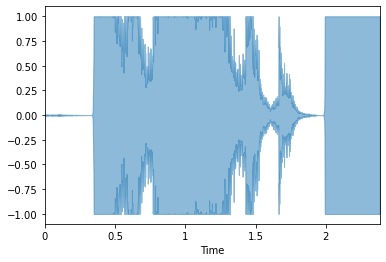

Datasets\Projeto\AudiosOriginais\GlassBreaking\4-204777-B_0003 - descartar:False


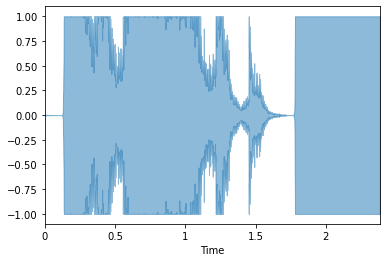

-------------------------------------------------------
[[0.10980034]
 [0.88396955]]
Datasets\Projeto\AudiosOriginais\GlassBreaking\4-204777-C_0001 - descartar:False


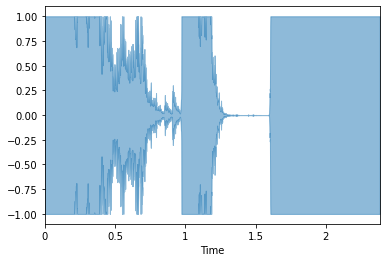

Datasets\Projeto\AudiosOriginais\GlassBreaking\4-204777-C_0002 - descartar:False


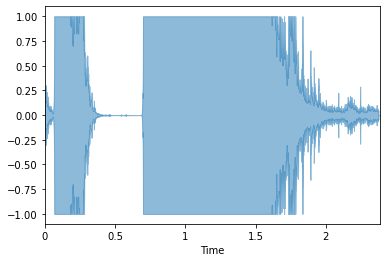

-------------------------------------------------------
Datasets\Projeto\AudiosOriginais\GlassBreaking\4-212698-A_0001 - descartar:False


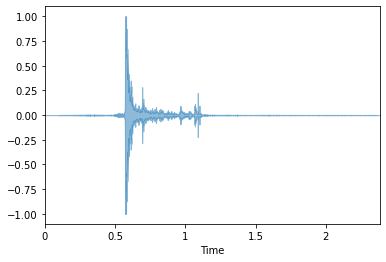

Datasets\Projeto\AudiosOriginais\GlassBreaking\4-212698-A_0002 - descartar:False


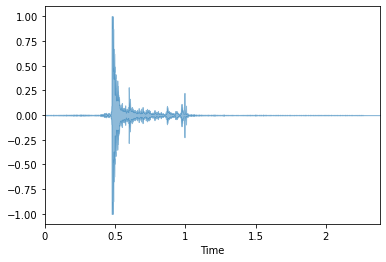

-------------------------------------------------------
Datasets\Projeto\AudiosOriginais\GlassBreaking\5-221528-A_0001 - descartar:False


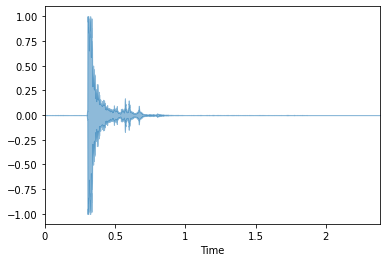

Datasets\Projeto\AudiosOriginais\GlassBreaking\5-221528-A_0002 - descartar:False


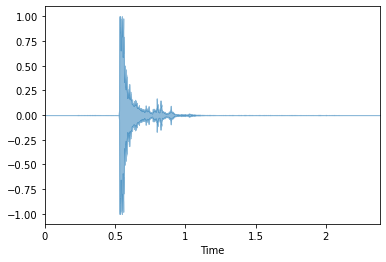

-------------------------------------------------------
Datasets\Projeto\AudiosOriginais\GlassBreaking\5-221529-A_0001 - descartar:False


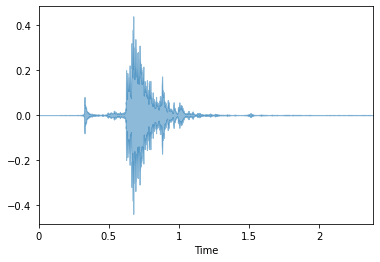

Datasets\Projeto\AudiosOriginais\GlassBreaking\5-221529-A_0002 - descartar:False


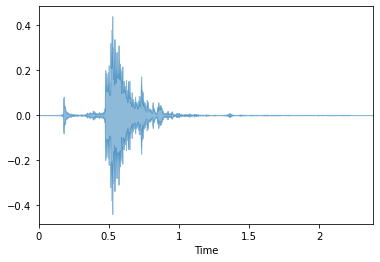

-------------------------------------------------------
Datasets\Projeto\AudiosOriginais\GlassBreaking\5-233605-A_0001 - descartar:False


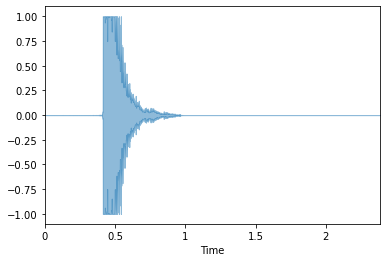

Datasets\Projeto\AudiosOriginais\GlassBreaking\5-233605-A_0002 - descartar:False


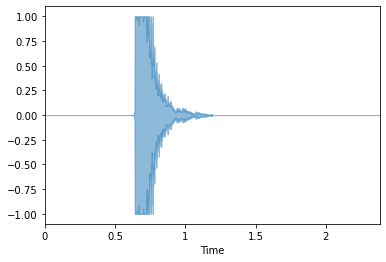

Datasets\Projeto\AudiosOriginais\GlassBreaking\5-233605-A_0003 - descartar:False


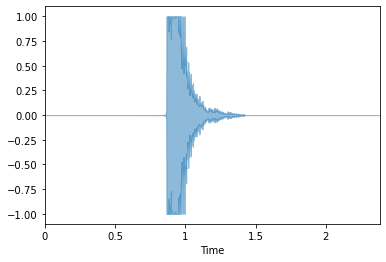

Datasets\Projeto\AudiosOriginais\GlassBreaking\5-233605-A_0004 - descartar:False


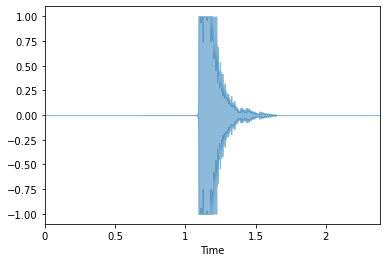

Datasets\Projeto\AudiosOriginais\GlassBreaking\5-233605-A_0005 - descartar:False


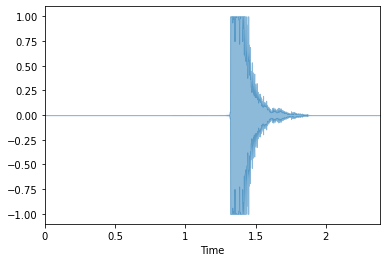

Datasets\Projeto\AudiosOriginais\GlassBreaking\5-233605-A_0006 - descartar:False


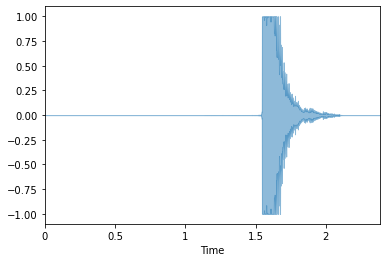

-------------------------------------------------------
Datasets\Projeto\AudiosOriginais\GlassBreaking\5-233607-A_0001 - descartar:False


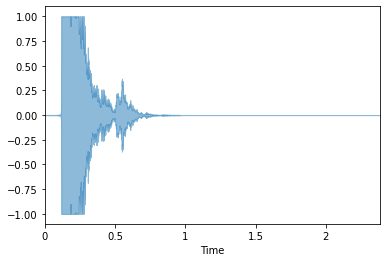

Datasets\Projeto\AudiosOriginais\GlassBreaking\5-233607-A_0002 - descartar:False


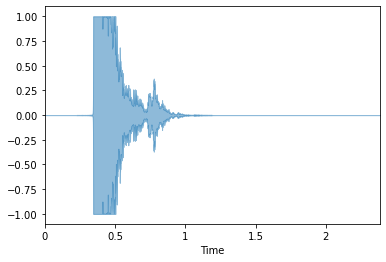

Datasets\Projeto\AudiosOriginais\GlassBreaking\5-233607-A_0003 - descartar:False


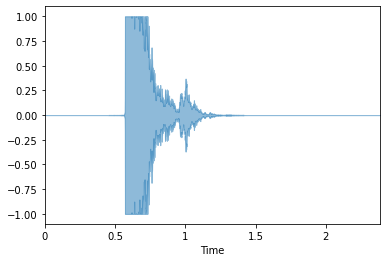

Datasets\Projeto\AudiosOriginais\GlassBreaking\5-233607-A_0004 - descartar:False


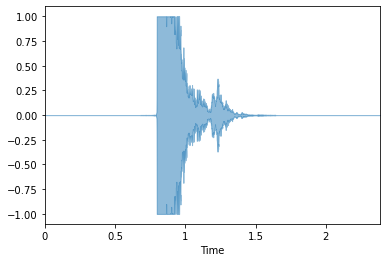

Datasets\Projeto\AudiosOriginais\GlassBreaking\5-233607-A_0005 - descartar:False


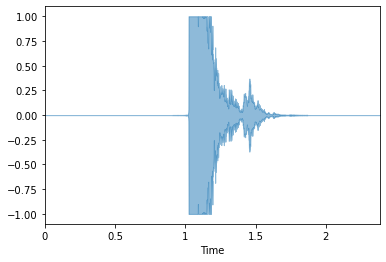

Datasets\Projeto\AudiosOriginais\GlassBreaking\5-233607-A_0006 - descartar:False


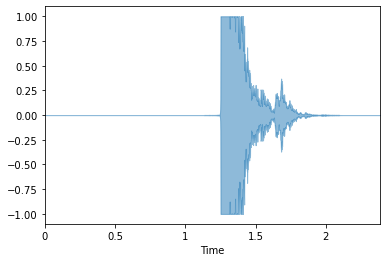

-------------------------------------------------------
[[0.00400721]
 [0.23861454]
 [0.10153249]]
Datasets\Projeto\AudiosOriginais\GlassBreaking\5-257642-A_0001 - descartar:False


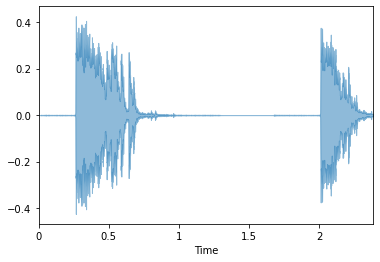

Datasets\Projeto\AudiosOriginais\GlassBreaking\5-257642-A_0002 - descartar:False


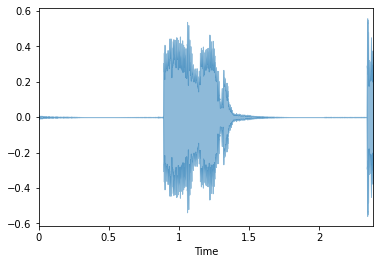

Datasets\Projeto\AudiosOriginais\GlassBreaking\5-257642-A_0003 - descartar:False


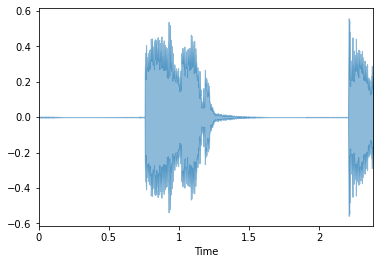

-------------------------------------------------------
Datasets\Projeto\AudiosOriginais\GlassBreaking\5-260432-A_0001 - descartar:False


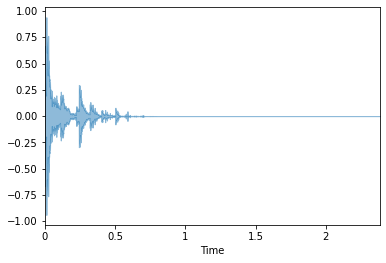

Datasets\Projeto\AudiosOriginais\GlassBreaking\5-260432-A_0002 - descartar:False


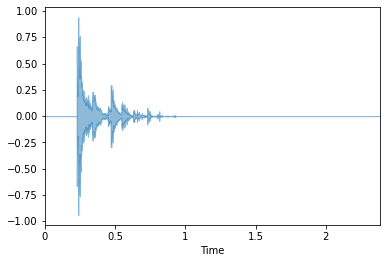

Datasets\Projeto\AudiosOriginais\GlassBreaking\5-260432-A_0003 - descartar:False


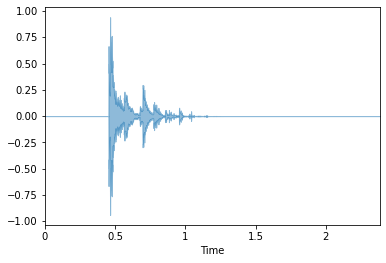

Datasets\Projeto\AudiosOriginais\GlassBreaking\5-260432-A_0004 - descartar:False


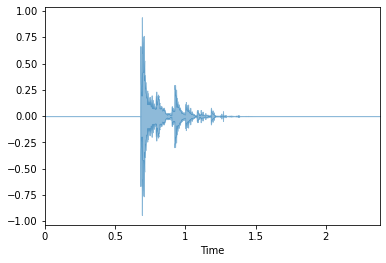

Datasets\Projeto\AudiosOriginais\GlassBreaking\5-260432-A_0005 - descartar:False


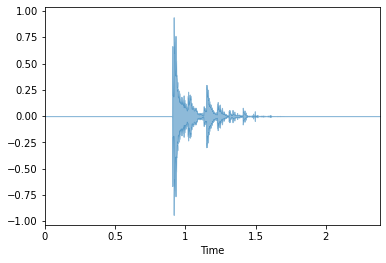

Datasets\Projeto\AudiosOriginais\GlassBreaking\5-260432-A_0006 - descartar:False


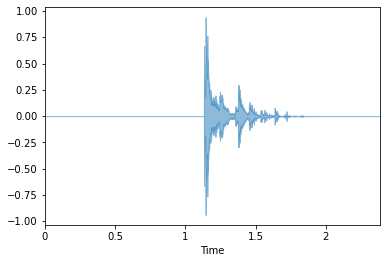

-------------------------------------------------------
Datasets\Projeto\AudiosOriginais\GlassBreaking\5-260433-A_0001 - descartar:False


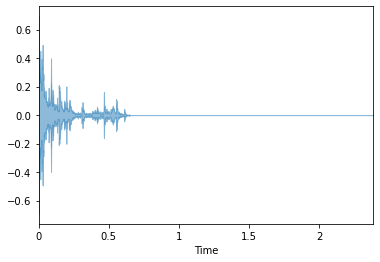

Datasets\Projeto\AudiosOriginais\GlassBreaking\5-260433-A_0002 - descartar:False


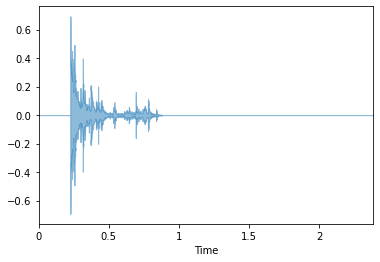

Datasets\Projeto\AudiosOriginais\GlassBreaking\5-260433-A_0003 - descartar:False


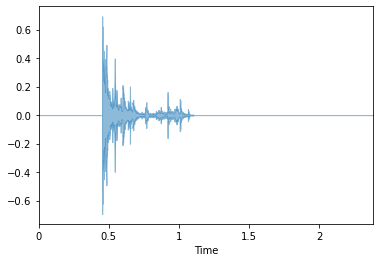

Datasets\Projeto\AudiosOriginais\GlassBreaking\5-260433-A_0004 - descartar:False


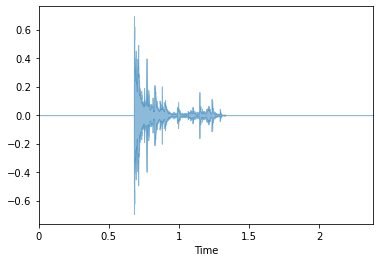

Datasets\Projeto\AudiosOriginais\GlassBreaking\5-260433-A_0005 - descartar:False


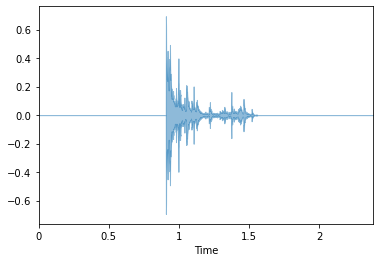

Datasets\Projeto\AudiosOriginais\GlassBreaking\5-260433-A_0006 - descartar:False


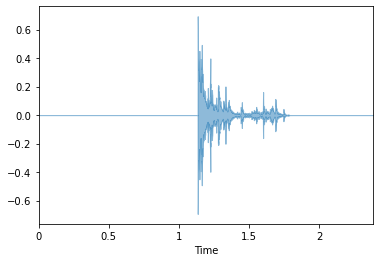

Datasets\Projeto\AudiosOriginais\GlassBreaking\5-260433-A_0007 - descartar:False


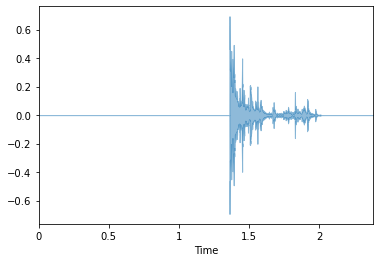

-------------------------------------------------------
Datasets\Projeto\AudiosOriginais\GlassBreaking\5-260434-A_0001 - descartar:False


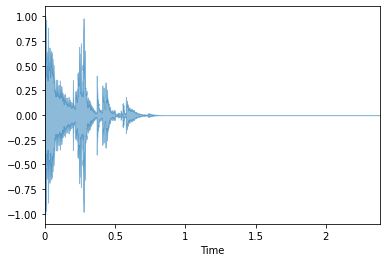

Datasets\Projeto\AudiosOriginais\GlassBreaking\5-260434-A_0002 - descartar:False


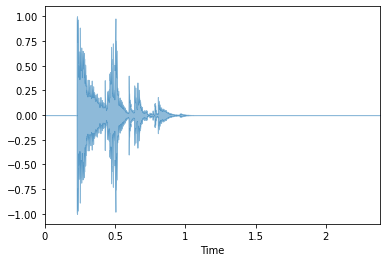

Datasets\Projeto\AudiosOriginais\GlassBreaking\5-260434-A_0003 - descartar:False


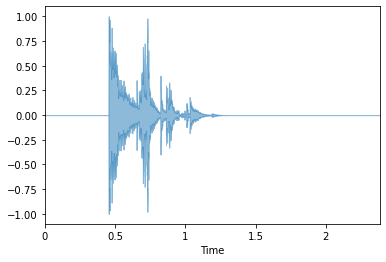

Datasets\Projeto\AudiosOriginais\GlassBreaking\5-260434-A_0004 - descartar:False


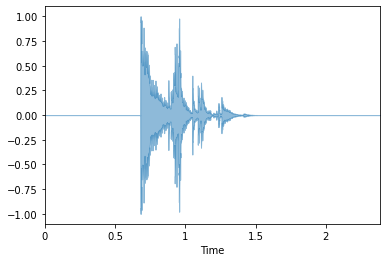

Datasets\Projeto\AudiosOriginais\GlassBreaking\5-260434-A_0005 - descartar:False


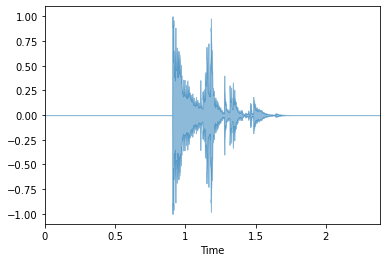

Datasets\Projeto\AudiosOriginais\GlassBreaking\5-260434-A_0006 - descartar:False


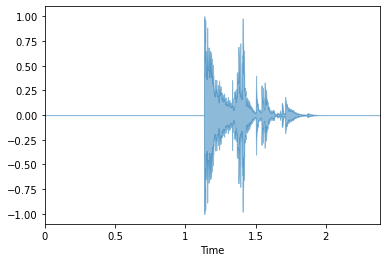

-------------------------------------------------------
[[0.00621165]
 [0.06424744]
 [0.1726279 ]]
Datasets\Projeto\AudiosOriginais\WaterDrops\1-12653-A_0001 - descartar:False


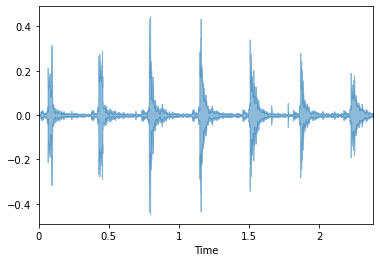

Datasets\Projeto\AudiosOriginais\WaterDrops\1-12653-A_0002 - descartar:False


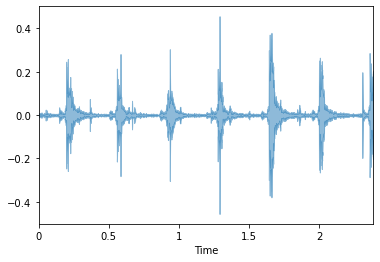

Datasets\Projeto\AudiosOriginais\WaterDrops\1-12653-A_0003 - descartar:False


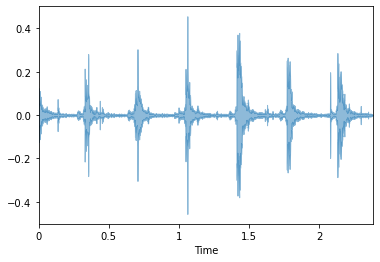

-------------------------------------------------------
[[0.00179926]
 [0.33536848]
 [0.08117361]]
Datasets\Projeto\AudiosOriginais\WaterDrops\1-12654-A_0001 - descartar:False


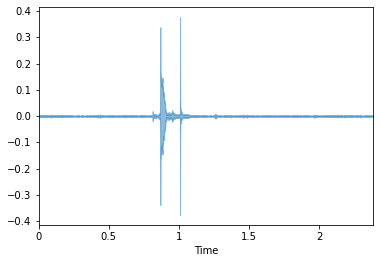

Datasets\Projeto\AudiosOriginais\WaterDrops\1-12654-A_0002 - descartar:False


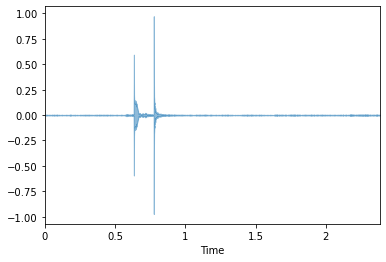

Datasets\Projeto\AudiosOriginais\WaterDrops\1-12654-A_0003 - descartar:False


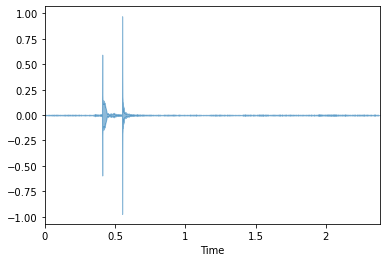

-------------------------------------------------------
[[0.00179047]
 [0.15348199]
 [0.04733368]]
Datasets\Projeto\AudiosOriginais\WaterDrops\1-12654-B_0001 - descartar:False


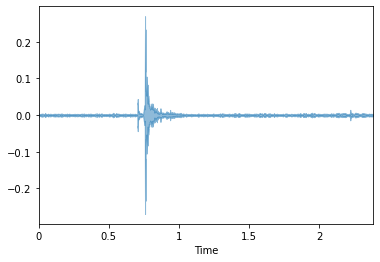

Datasets\Projeto\AudiosOriginais\WaterDrops\1-12654-B_0002 - descartar:False


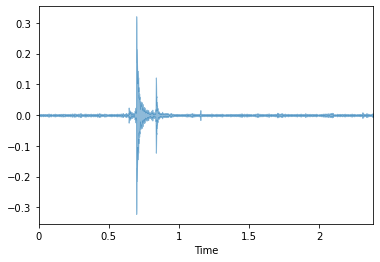

Datasets\Projeto\AudiosOriginais\WaterDrops\1-12654-B_0003 - descartar:False


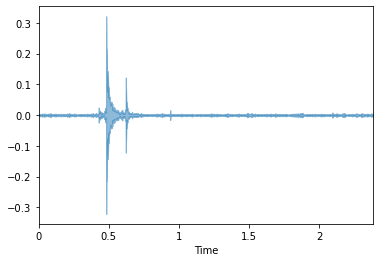

-------------------------------------------------------
Datasets\Projeto\AudiosOriginais\WaterDrops\1-16746-A_0001 - descartar:False


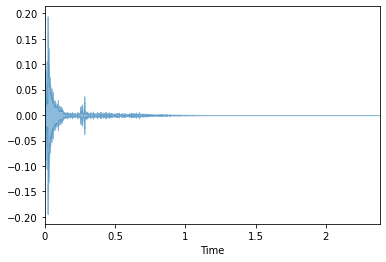

Datasets\Projeto\AudiosOriginais\WaterDrops\1-16746-A_0002 - descartar:False


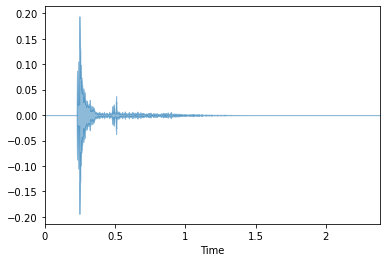

Datasets\Projeto\AudiosOriginais\WaterDrops\1-16746-A_0003 - descartar:False


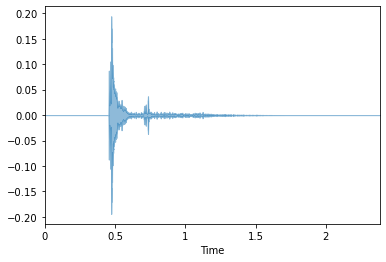

Datasets\Projeto\AudiosOriginais\WaterDrops\1-16746-A_0004 - descartar:False


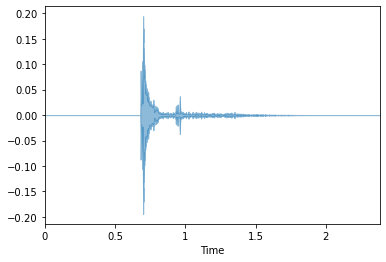

Datasets\Projeto\AudiosOriginais\WaterDrops\1-16746-A_0005 - descartar:False


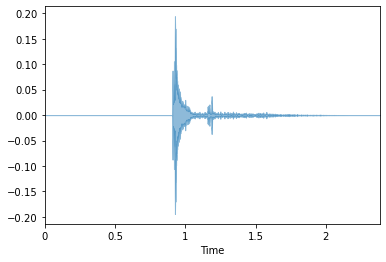

-------------------------------------------------------
[[0.00255621]
 [0.13941947]
 [0.03621339]]
Datasets\Projeto\AudiosOriginais\WaterDrops\1-23094-A_0001 - descartar:False


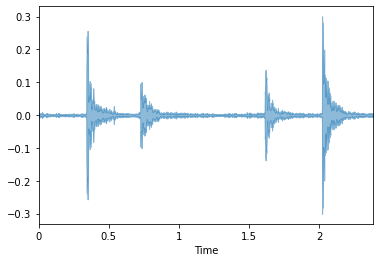

Datasets\Projeto\AudiosOriginais\WaterDrops\1-23094-A_0002 - descartar:True


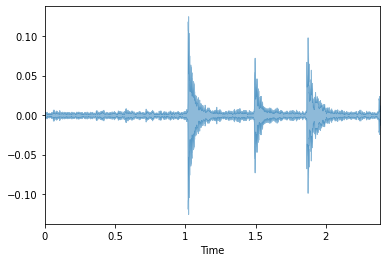

Datasets\Projeto\AudiosOriginais\WaterDrops\1-23094-A_0003 - descartar:True


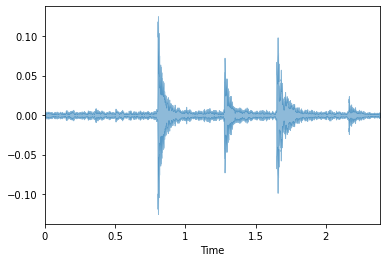

-------------------------------------------------------
[[0.00242665]
 [0.05894671]
 [0.01989587]]
Datasets\Projeto\AudiosOriginais\WaterDrops\1-23094-B_0001 - descartar:False


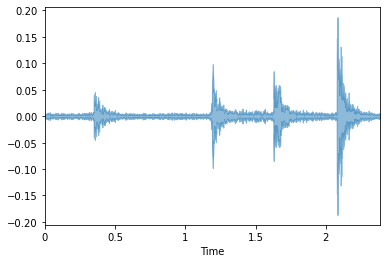

Datasets\Projeto\AudiosOriginais\WaterDrops\1-23094-B_0002 - descartar:False


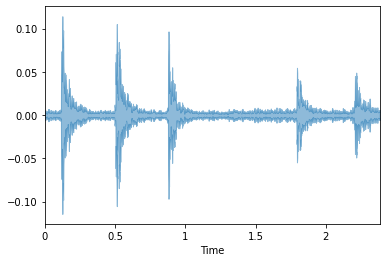

Datasets\Projeto\AudiosOriginais\WaterDrops\1-23094-B_0003 - descartar:False


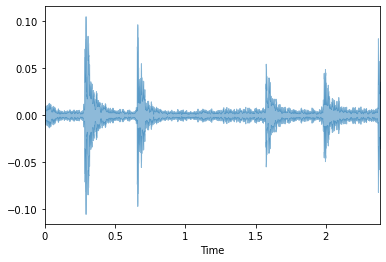

-------------------------------------------------------
[[0.00073241]
 [0.04245419]
 [0.2933775 ]]
Datasets\Projeto\AudiosOriginais\WaterDrops\1-50623-A_0001 - descartar:False


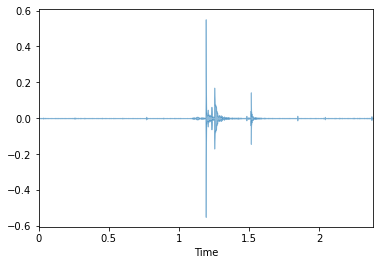

Datasets\Projeto\AudiosOriginais\WaterDrops\1-50623-A_0002 - descartar:True


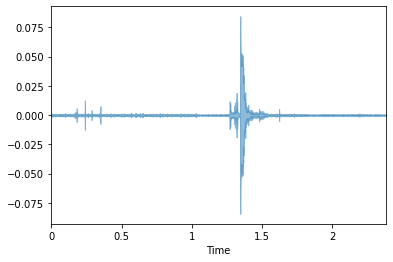

Datasets\Projeto\AudiosOriginais\WaterDrops\1-50623-A_0003 - descartar:False


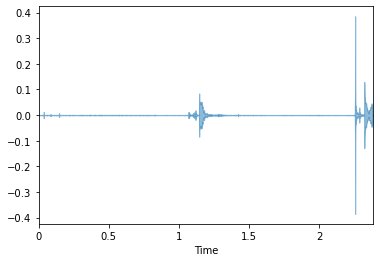

-------------------------------------------------------
[[0.00533375]
 [0.1460251 ]]
Datasets\Projeto\AudiosOriginais\WaterDrops\1-90797-A_0001 - descartar:False


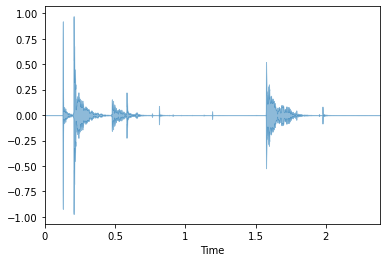

Datasets\Projeto\AudiosOriginais\WaterDrops\1-90797-A_0002 - descartar:False


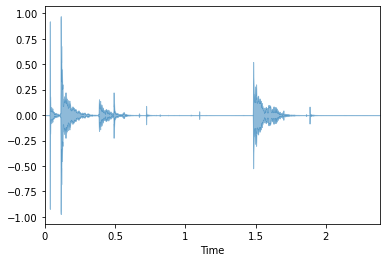

-------------------------------------------------------
[[0.00628201]
 [0.14293042]
 [0.03961084]]
Datasets\Projeto\AudiosOriginais\WaterDrops\2-124564-A_0001 - descartar:False


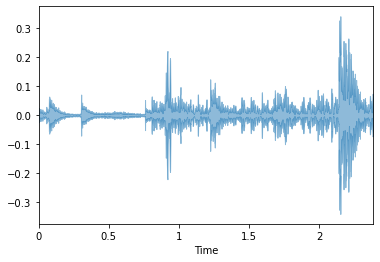

Datasets\Projeto\AudiosOriginais\WaterDrops\2-124564-A_0002 - descartar:False


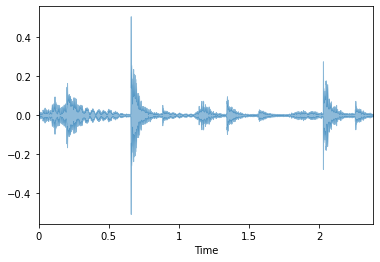

Datasets\Projeto\AudiosOriginais\WaterDrops\2-124564-A_0003 - descartar:False


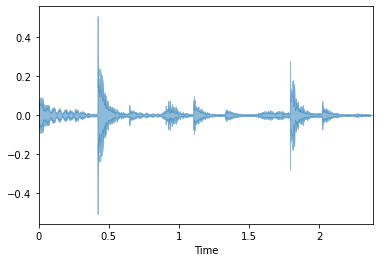

-------------------------------------------------------
[[0.00228328]
 [0.01462512]
 [0.04046489]]
Datasets\Projeto\AudiosOriginais\WaterDrops\2-139748-A_0001 - descartar:False


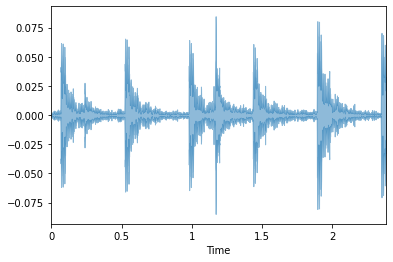

Datasets\Projeto\AudiosOriginais\WaterDrops\2-139748-A_0002 - descartar:False


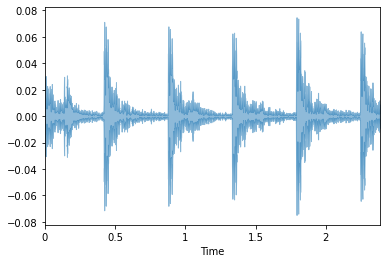

Datasets\Projeto\AudiosOriginais\WaterDrops\2-139748-A_0003 - descartar:False


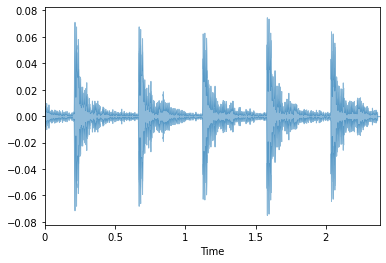

-------------------------------------------------------
[[0.0022515 ]
 [0.03915603]
 [0.01466801]]
Datasets\Projeto\AudiosOriginais\WaterDrops\2-139748-B_0001 - descartar:False


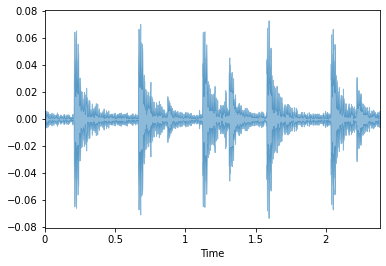

Datasets\Projeto\AudiosOriginais\WaterDrops\2-139748-B_0002 - descartar:False


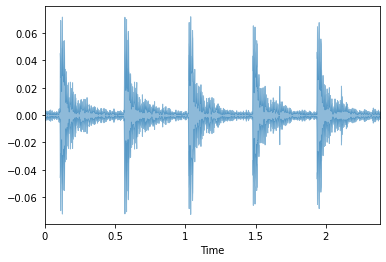

Datasets\Projeto\AudiosOriginais\WaterDrops\2-139748-B_0003 - descartar:False


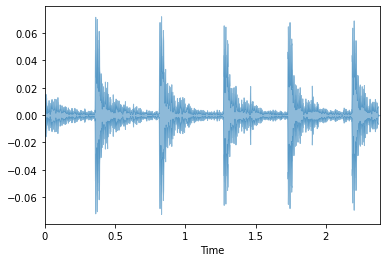

-------------------------------------------------------
[[0.00052441]
 [0.03673851]
 [0.01093787]]
Datasets\Projeto\AudiosOriginais\WaterDrops\2-139749-A_0001 - descartar:False


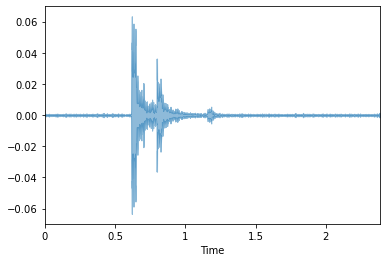

Datasets\Projeto\AudiosOriginais\WaterDrops\2-139749-A_0002 - descartar:False


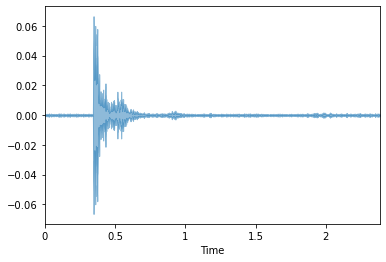

Datasets\Projeto\AudiosOriginais\WaterDrops\2-139749-A_0003 - descartar:False


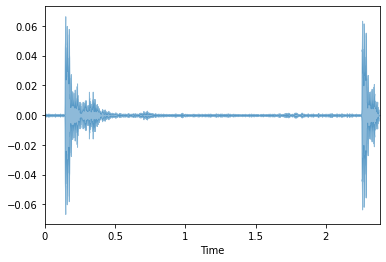

-------------------------------------------------------
[[0.063563  ]
 [0.00423445]
 [0.02072239]]
Datasets\Projeto\AudiosOriginais\WaterDrops\2-64962-A_0001 - descartar:False


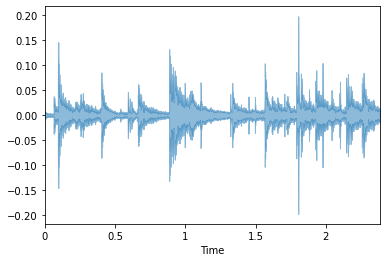

Datasets\Projeto\AudiosOriginais\WaterDrops\2-64962-A_0002 - descartar:False


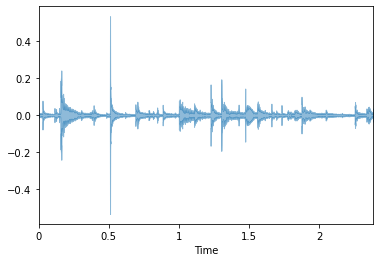

Datasets\Projeto\AudiosOriginais\WaterDrops\2-64962-A_0003 - descartar:False


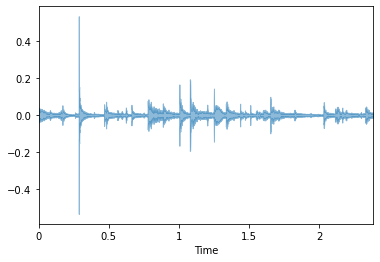

-------------------------------------------------------
[[0.00311349]
 [0.02616198]
 [0.0903855 ]]
Datasets\Projeto\AudiosOriginais\WaterDrops\2-64963-A_0001 - descartar:False


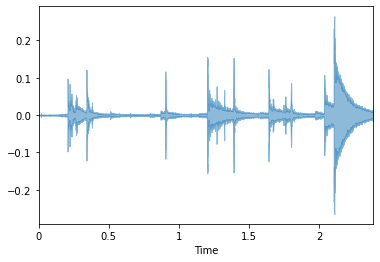

Datasets\Projeto\AudiosOriginais\WaterDrops\2-64963-A_0002 - descartar:False


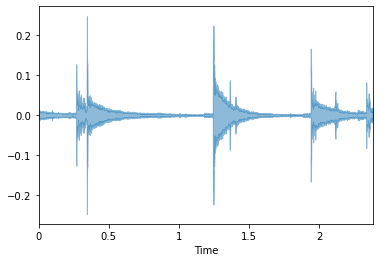

Datasets\Projeto\AudiosOriginais\WaterDrops\2-64963-A_0003 - descartar:False


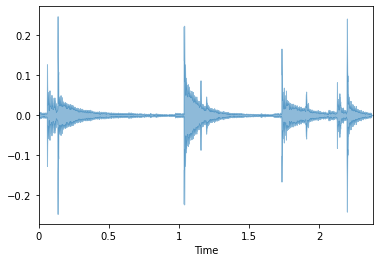

-------------------------------------------------------
[[0.00218946]
 [0.1287089 ]
 [0.04221235]]
Datasets\Projeto\AudiosOriginais\WaterDrops\2-68595-A_0001 - descartar:False


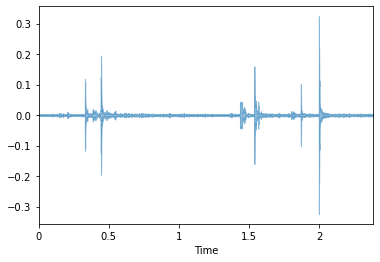

Datasets\Projeto\AudiosOriginais\WaterDrops\2-68595-A_0002 - descartar:False


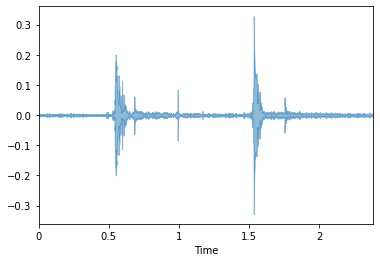

Datasets\Projeto\AudiosOriginais\WaterDrops\2-68595-A_0003 - descartar:False


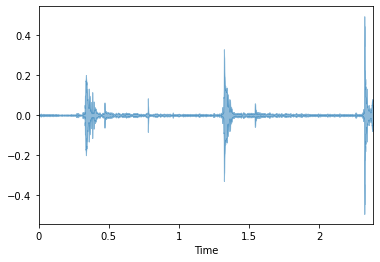

-------------------------------------------------------
[[0.00199024]
 [0.05346793]]
Datasets\Projeto\AudiosOriginais\WaterDrops\2-68595-B_0001 - descartar:False


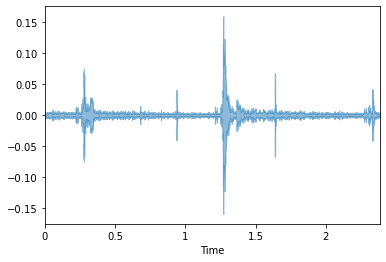

Datasets\Projeto\AudiosOriginais\WaterDrops\2-68595-B_0002 - descartar:False


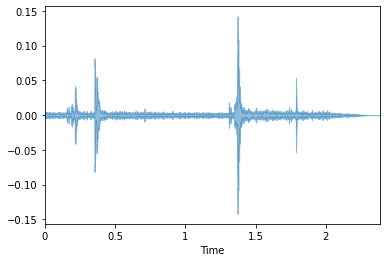

-------------------------------------------------------
[[0.00194574]
 [0.15033075]]
Datasets\Projeto\AudiosOriginais\WaterDrops\3-156907-A_0001 - descartar:False


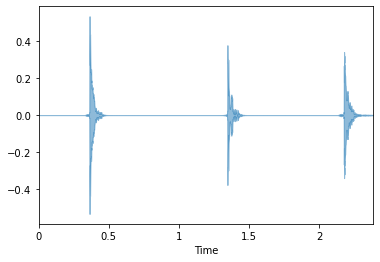

Datasets\Projeto\AudiosOriginais\WaterDrops\3-156907-A_0002 - descartar:False


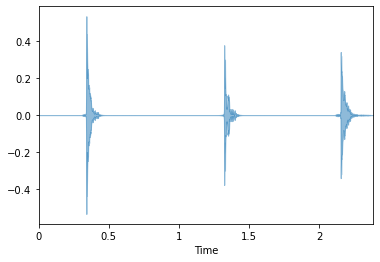

-------------------------------------------------------
Datasets\Projeto\AudiosOriginais\WaterDrops\3-160119-A_0001 - descartar:False


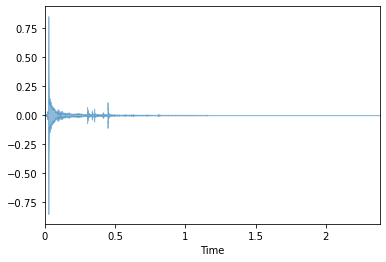

Datasets\Projeto\AudiosOriginais\WaterDrops\3-160119-A_0002 - descartar:False


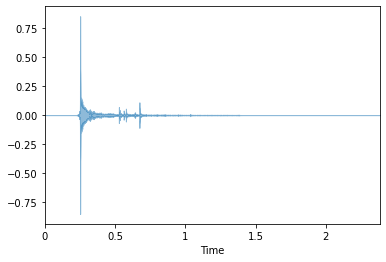

Datasets\Projeto\AudiosOriginais\WaterDrops\3-160119-A_0003 - descartar:False


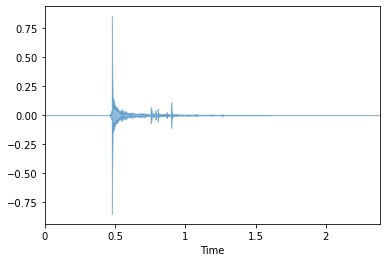

Datasets\Projeto\AudiosOriginais\WaterDrops\3-160119-A_0004 - descartar:False


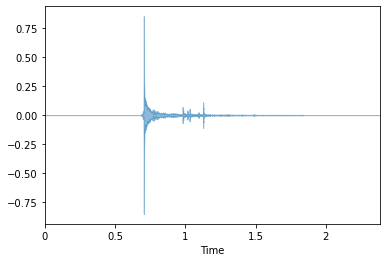

Datasets\Projeto\AudiosOriginais\WaterDrops\3-160119-A_0005 - descartar:False


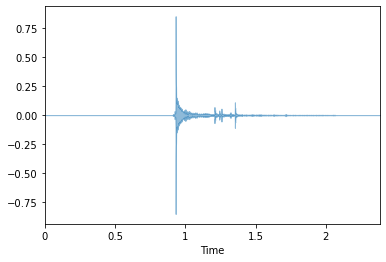

-------------------------------------------------------
Datasets\Projeto\AudiosOriginais\WaterDrops\3-164592-A_0001 - descartar:False


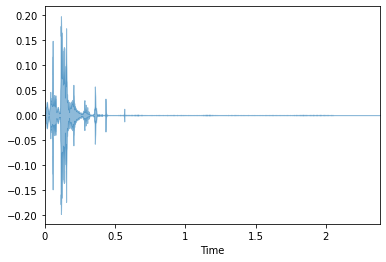

-------------------------------------------------------
[[0.00312724]
 [0.26723894]]
Datasets\Projeto\AudiosOriginais\WaterDrops\3-164593-A_0001 - descartar:False


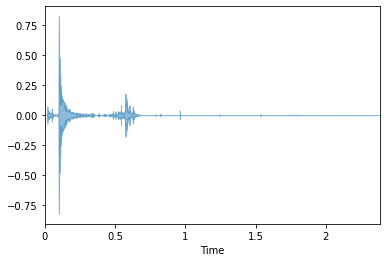

Datasets\Projeto\AudiosOriginais\WaterDrops\3-164593-A_0002 - descartar:False


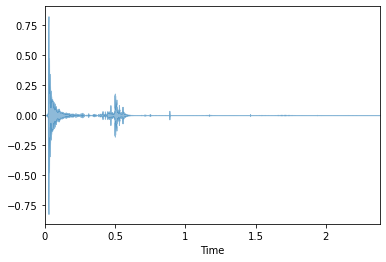

-------------------------------------------------------
Datasets\Projeto\AudiosOriginais\WaterDrops\3-164594-A_0001 - descartar:False


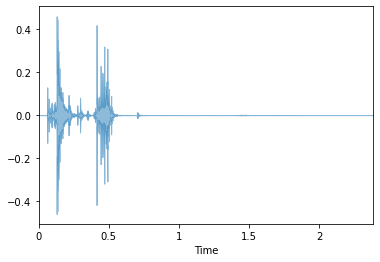

Datasets\Projeto\AudiosOriginais\WaterDrops\3-164594-A_0002 - descartar:False


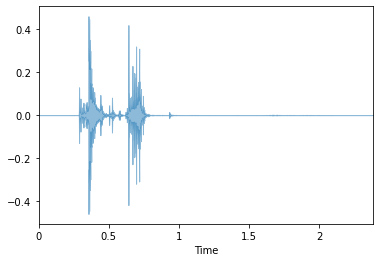

-------------------------------------------------------
Datasets\Projeto\AudiosOriginais\WaterDrops\3-164595-A_0001 - descartar:False


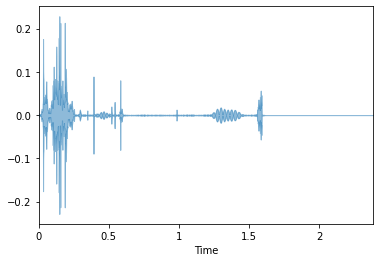

Datasets\Projeto\AudiosOriginais\WaterDrops\3-164595-A_0002 - descartar:False


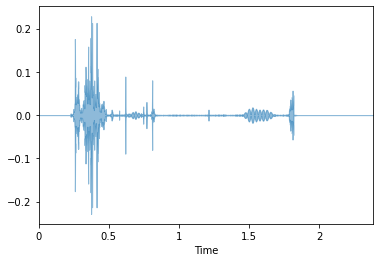

Datasets\Projeto\AudiosOriginais\WaterDrops\3-164595-A_0003 - descartar:False


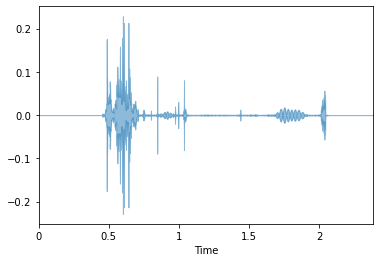

-------------------------------------------------------
[[0.0005451 ]
 [0.07140493]
 [0.0180524 ]]
Datasets\Projeto\AudiosOriginais\WaterDrops\3-166324-A_0001 - descartar:False


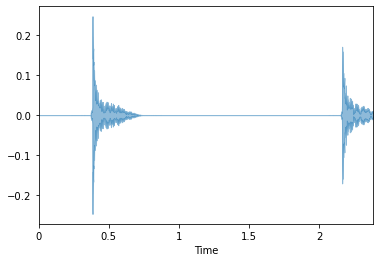

Datasets\Projeto\AudiosOriginais\WaterDrops\3-166324-A_0002 - descartar:False


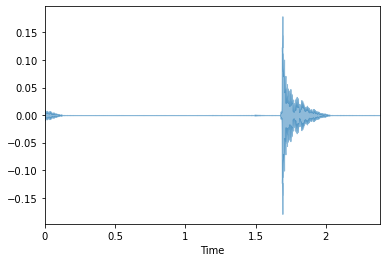

Datasets\Projeto\AudiosOriginais\WaterDrops\3-166324-A_0003 - descartar:False


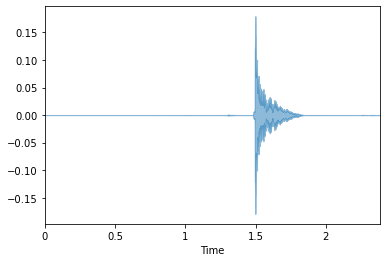

-------------------------------------------------------
[[0.001684  ]
 [0.0206765 ]
 [0.05867362]]
Datasets\Projeto\AudiosOriginais\WaterDrops\3-166326-A_0001 - descartar:False


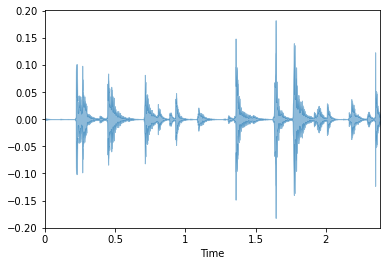

Datasets\Projeto\AudiosOriginais\WaterDrops\3-166326-A_0002 - descartar:False


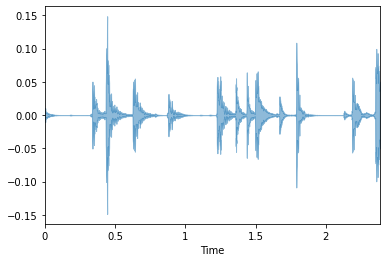

Datasets\Projeto\AudiosOriginais\WaterDrops\3-166326-A_0003 - descartar:False


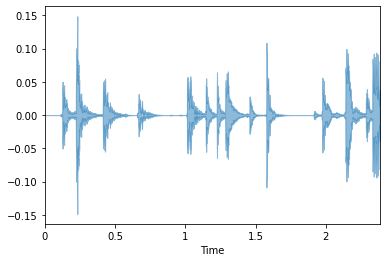

-------------------------------------------------------
[[0.00561687]
 [0.27652976]
 [0.10844097]]
Datasets\Projeto\AudiosOriginais\WaterDrops\4-168155-A_0001 - descartar:False


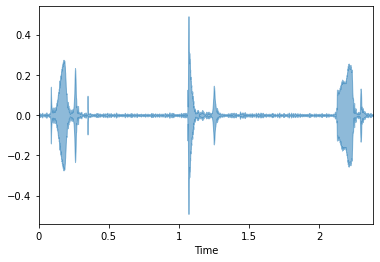

Datasets\Projeto\AudiosOriginais\WaterDrops\4-168155-A_0002 - descartar:False


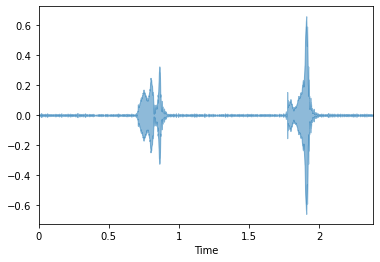

Datasets\Projeto\AudiosOriginais\WaterDrops\4-168155-A_0003 - descartar:False


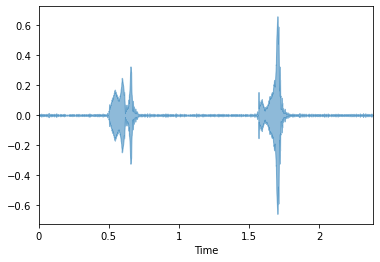

-------------------------------------------------------
[[0.00902541]
 [0.3756586 ]
 [0.1237882 ]]
Datasets\Projeto\AudiosOriginais\WaterDrops\4-174797-A_0001 - descartar:False


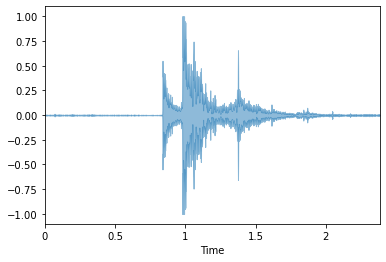

Datasets\Projeto\AudiosOriginais\WaterDrops\4-174797-A_0002 - descartar:False


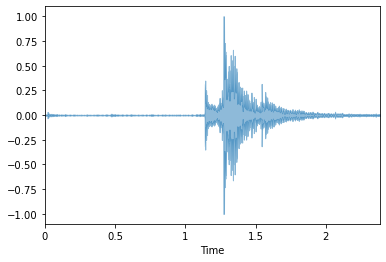

Datasets\Projeto\AudiosOriginais\WaterDrops\4-174797-A_0003 - descartar:False


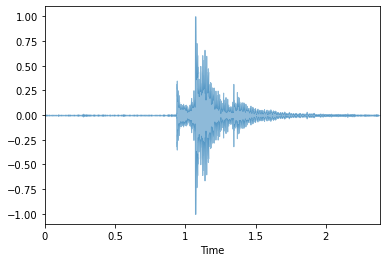

-------------------------------------------------------
[[0.00147819]
 [0.09299461]
 [0.03540404]]
Datasets\Projeto\AudiosOriginais\WaterDrops\4-188293-A_0001 - descartar:False


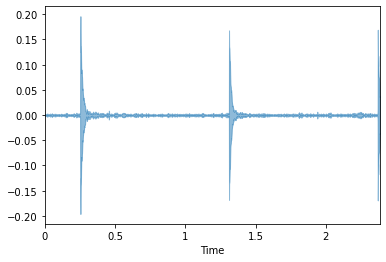

Datasets\Projeto\AudiosOriginais\WaterDrops\4-188293-A_0002 - descartar:False


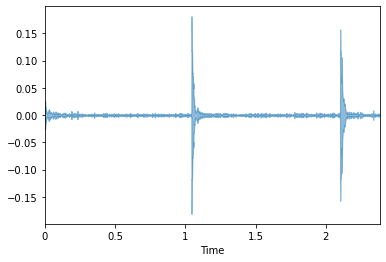

Datasets\Projeto\AudiosOriginais\WaterDrops\4-188293-A_0003 - descartar:False


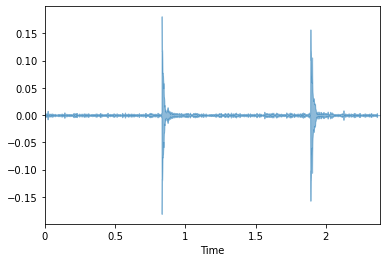

-------------------------------------------------------
[[0.00153534]
 [0.09845359]
 [0.0376933 ]]
Datasets\Projeto\AudiosOriginais\WaterDrops\4-188293-B_0001 - descartar:False


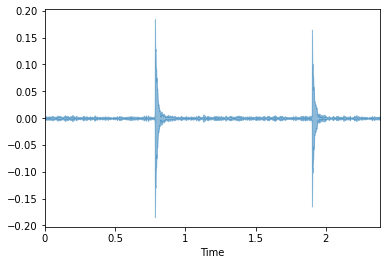

Datasets\Projeto\AudiosOriginais\WaterDrops\4-188293-B_0002 - descartar:False


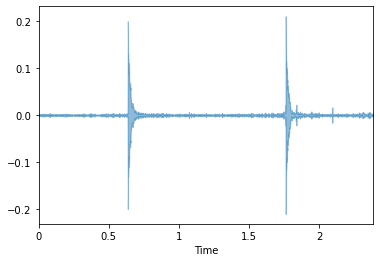

Datasets\Projeto\AudiosOriginais\WaterDrops\4-188293-B_0003 - descartar:False


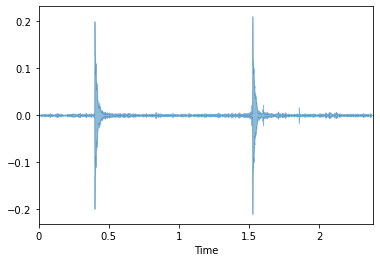

-------------------------------------------------------
Datasets\Projeto\AudiosOriginais\WaterDrops\4-197871-A_0001 - descartar:False


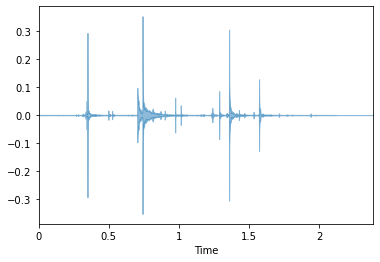

-------------------------------------------------------
[[0.00856004]
 [0.02962471]
 [0.21039744]]
Datasets\Projeto\AudiosOriginais\WaterDrops\4-212604-A_0001 - descartar:False


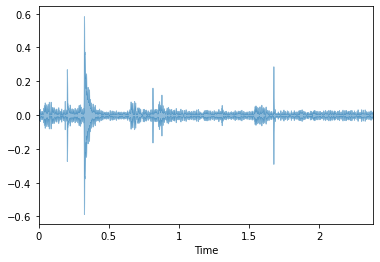

Datasets\Projeto\AudiosOriginais\WaterDrops\4-212604-A_0002 - descartar:True


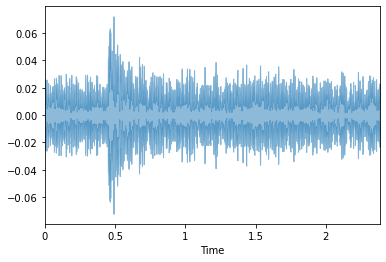

Datasets\Projeto\AudiosOriginais\WaterDrops\4-212604-A_0003 - descartar:True


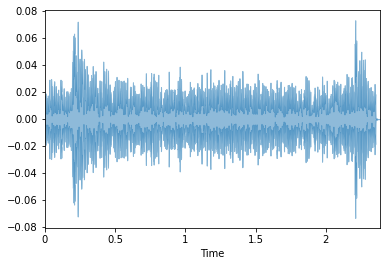

-------------------------------------------------------
[[0.0169729 ]
 [0.50425565]
 [0.14670357]]
Datasets\Projeto\AudiosOriginais\WaterDrops\4-212604-B_0001 - descartar:False


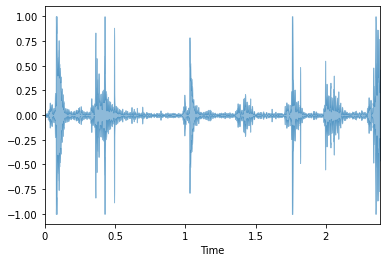

Datasets\Projeto\AudiosOriginais\WaterDrops\4-212604-B_0002 - descartar:False


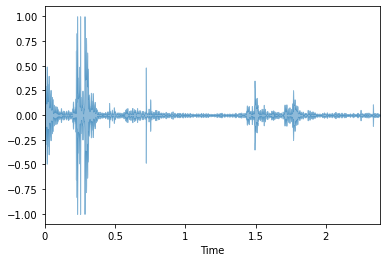

Datasets\Projeto\AudiosOriginais\WaterDrops\4-212604-B_0003 - descartar:False


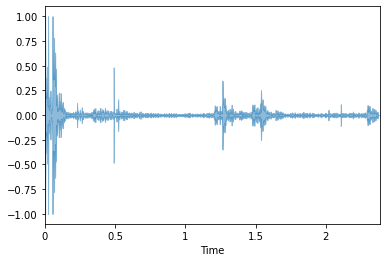

-------------------------------------------------------
[[0.14149153]
 [0.60401505]
 [0.0127636 ]]
Datasets\Projeto\AudiosOriginais\WaterDrops\4-212604-C_0001 - descartar:False


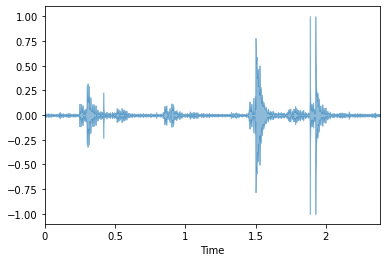

Datasets\Projeto\AudiosOriginais\WaterDrops\4-212604-C_0002 - descartar:False


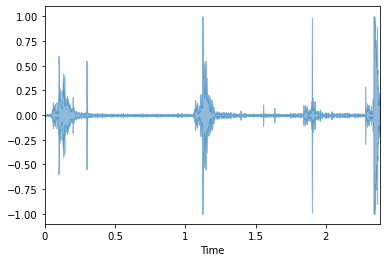

Datasets\Projeto\AudiosOriginais\WaterDrops\4-212604-C_0003 - descartar:False


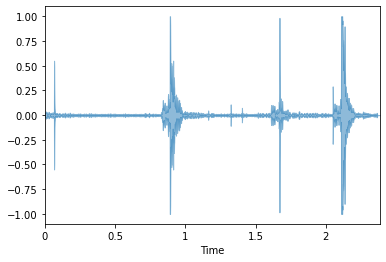

-------------------------------------------------------
[[0.00348522]
 [0.11173578]
 [0.40877295]]
Datasets\Projeto\AudiosOriginais\WaterDrops\5-241846-A_0001 - descartar:True


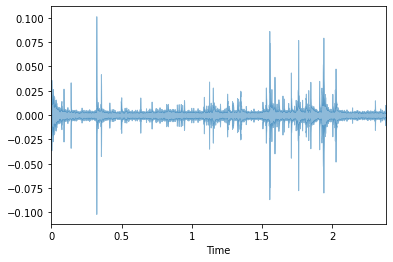

Datasets\Projeto\AudiosOriginais\WaterDrops\5-241846-A_0002 - descartar:False


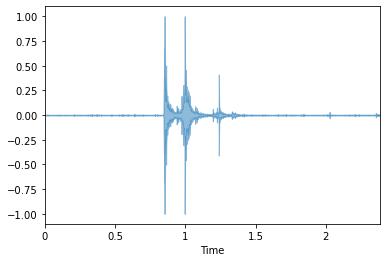

Datasets\Projeto\AudiosOriginais\WaterDrops\5-241846-A_0003 - descartar:False


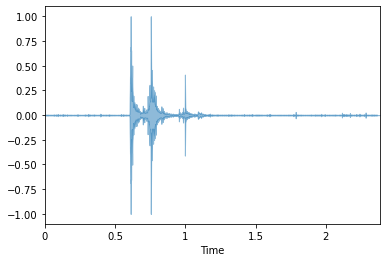

-------------------------------------------------------
[[0.00137879]
 [0.01182261]
 [0.03658382]]
Datasets\Projeto\AudiosOriginais\WaterDrops\5-254832-A_0001 - descartar:False


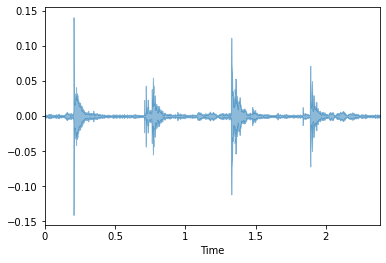

Datasets\Projeto\AudiosOriginais\WaterDrops\5-254832-A_0002 - descartar:False


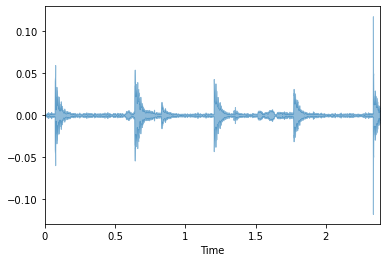

Datasets\Projeto\AudiosOriginais\WaterDrops\5-254832-A_0003 - descartar:False


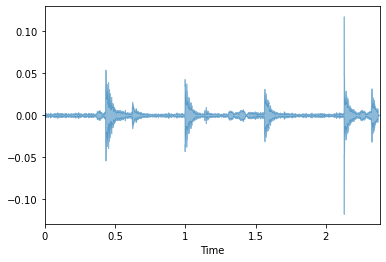

-------------------------------------------------------
[[0.05048409]
 [0.00136891]
 [0.01461595]]
Datasets\Projeto\AudiosOriginais\WaterDrops\5-254832-B_0001 - descartar:False


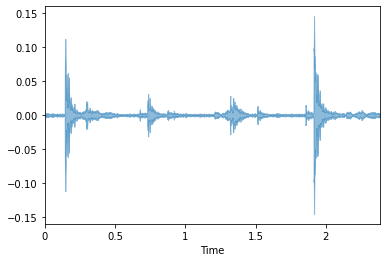

Datasets\Projeto\AudiosOriginais\WaterDrops\5-254832-B_0002 - descartar:False


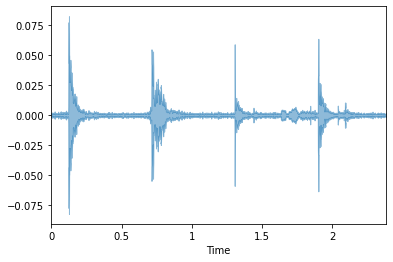

Datasets\Projeto\AudiosOriginais\WaterDrops\5-254832-B_0003 - descartar:False


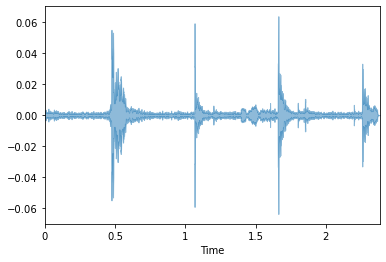

-------------------------------------------------------
[[0.00228795]
 [0.348502  ]
 [0.09741344]]
Datasets\Projeto\AudiosOriginais\WaterDrops\5-257349-A_0001 - descartar:False


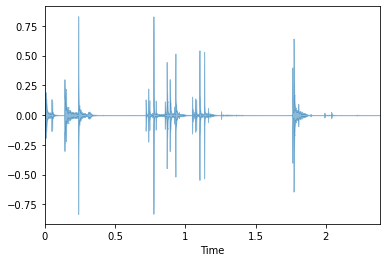

Datasets\Projeto\AudiosOriginais\WaterDrops\5-257349-A_0002 - descartar:False


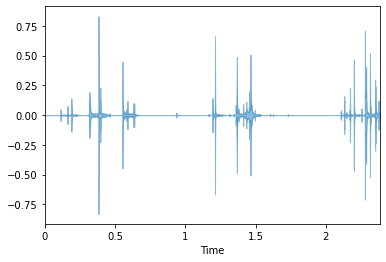

Datasets\Projeto\AudiosOriginais\WaterDrops\5-257349-A_0003 - descartar:False


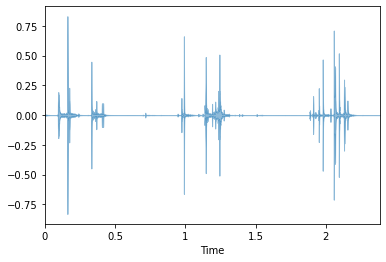

-------------------------------------------------------
Datasets\Projeto\AudiosOriginais\WaterDrops\5-259180-A_0001 - descartar:False


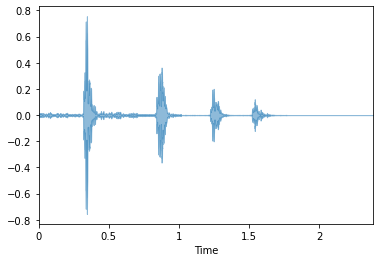

Datasets\Projeto\AudiosOriginais\WaterDrops\5-259180-A_0002 - descartar:False


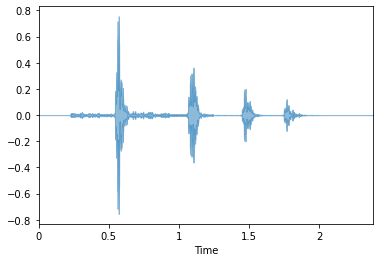

-------------------------------------------------------
Datasets\Projeto\AudiosOriginais\WaterDrops\5-261433-A_0001 - descartar:False


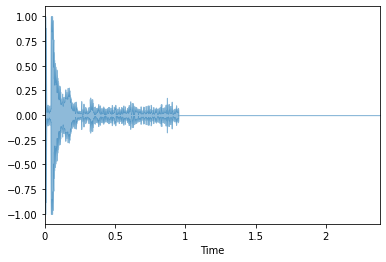

Datasets\Projeto\AudiosOriginais\WaterDrops\5-261433-A_0002 - descartar:False


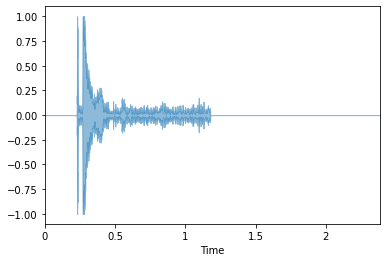

Datasets\Projeto\AudiosOriginais\WaterDrops\5-261433-A_0003 - descartar:False


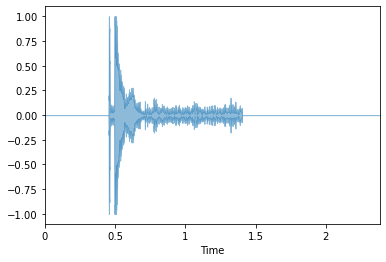

Datasets\Projeto\AudiosOriginais\WaterDrops\5-261433-A_0004 - descartar:False


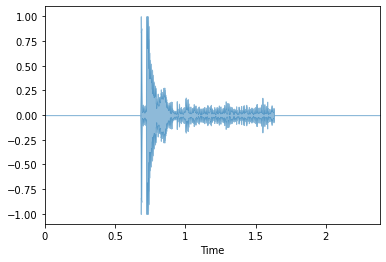

Datasets\Projeto\AudiosOriginais\WaterDrops\5-261433-A_0005 - descartar:False


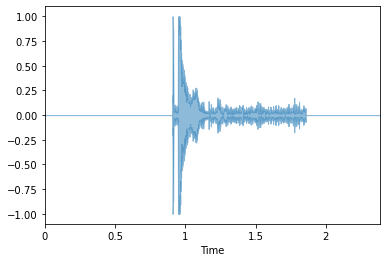

Datasets\Projeto\AudiosOriginais\WaterDrops\5-261433-A_0006 - descartar:False


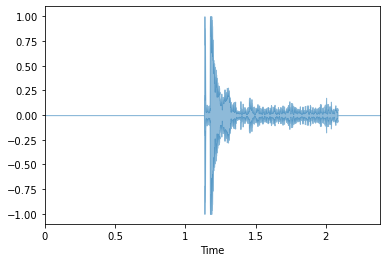

-------------------------------------------------------
[[0.00545287]
 [0.01737654]
 [0.03492835]]
Datasets\Projeto\AudiosOriginais\WaterDrops\5-261439-A_0001 - descartar:False


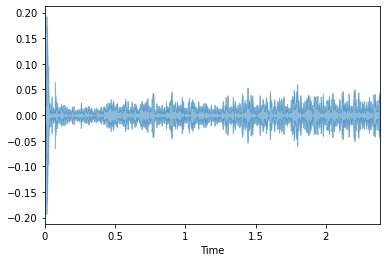

Datasets\Projeto\AudiosOriginais\WaterDrops\5-261439-A_0002 - descartar:False


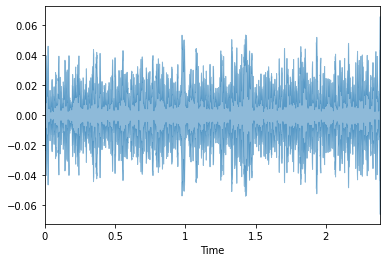

Datasets\Projeto\AudiosOriginais\WaterDrops\5-261439-A_0003 - descartar:False


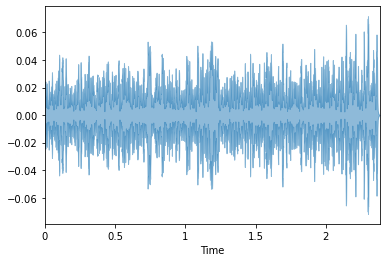

-------------------------------------------------------
[[0.0015178 ]
 [0.00985521]
 [0.00486278]]
Datasets\Projeto\AudiosOriginais\WaterDrops\5-262641-A_0001 - descartar:False


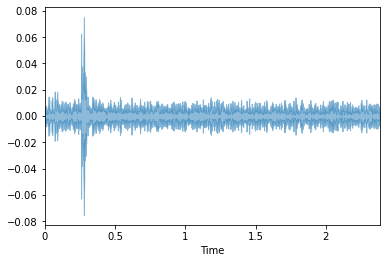

Datasets\Projeto\AudiosOriginais\WaterDrops\5-262641-A_0002 - descartar:False


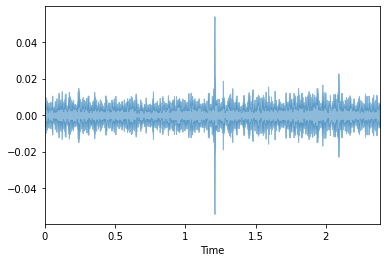

Datasets\Projeto\AudiosOriginais\WaterDrops\5-262641-A_0003 - descartar:False


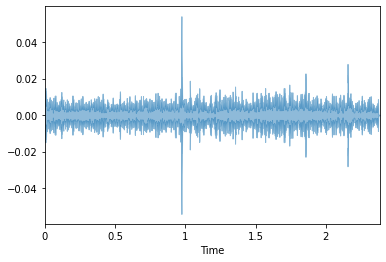

-------------------------------------------------------
fim - duração 204.6953320503235


In [12]:
print('inicio')
inicio = time.time()

allArqAudioSegDF = pd.DataFrame(columns=['diretorio','nome','segmento','tamanho','descartar'])

for row in allArqAudioDF.values.tolist():
    audSignal = row[2]
    audSignal = np.trim_zeros(audSignal)
    
    centroAltaFreq = None
    
    if(audSignal.size > 105000):
        centroAltaFreq = centroAltaFrequencia(audSignal)       

    audioSegments = audioSegmentation(audSignal, SEG_FRAME_SIZE, OFFSET_SIZE)
    plotaSegmentos(allArqAudioSegDF, audioSegments, 44100, centroAltaFreq, row)
    
    print('-------------------------------------------------------')
    
fim = time.time()
print('fim - duração {0}'.format(fim-inicio))

### Verificação do Tamanho Máximo dos Áudios Segmentados

In [13]:
allArqAudioSegDF['tamanho'].max()

105235

### Verificação do Tamanho Mínimo dos Áudios Segmentados

In [14]:
allArqAudioSegDF['tamanho'].min()

105235

### Estatísticas dos Descartes

In [15]:
allArqAudioSegDF['descartar'].describe()

count       390
unique        2
top       False
freq        364
Name: descartar, dtype: object

### Distribuição por Tamanho Segmentados

<AxesSubplot:ylabel='Frequency'>

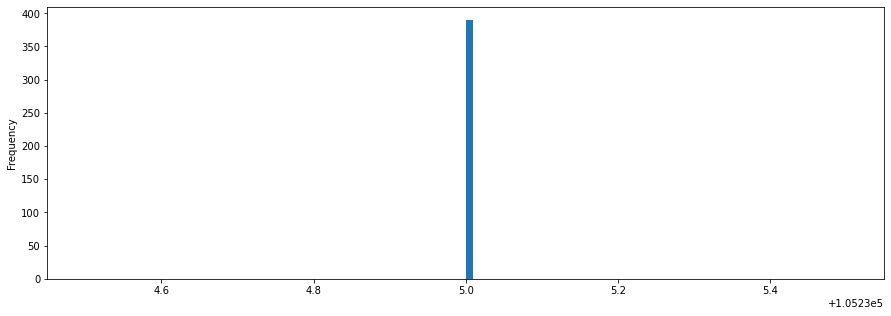

In [16]:
plt.figure(figsize=(15, 5))
allArqAudioSegDF['tamanho'].plot.hist(bins=100)


### Estatísticas dos Tamanhos Segmentados

In [17]:
allArqAudioSegDF['tamanho'].describe()

count        390
unique         1
top       105235
freq         390
Name: tamanho, dtype: int64

### Remoção do Dataframe dos Descartes e Totalização por Tipo

In [18]:
allArqAudioSegDFDescarte = allArqAudioSegDF.where(allArqAudioSegDF['descartar'] == False)
allArqAudioSegDFDescarte.dropna(inplace=True)
allArqAudioSegDFDescarte.groupby(['diretorio']).count()

nome  segmento  tamanho  descartar
diretorio                                        
CracklingFire   102       102      102        102
GlassBreaking   151       151      151        151
WaterDrops      111       111      111        111

### Declaração da Função Geradora do Espectrograma Mel

In [19]:
def geraSpectrograma(audioSignal, sampleRate):
    mel_spectrogram = librosa.feature.melspectrogram(audioSignal, sr=sampleRate, n_fft=FFT_FRAME_SIZE, 
                                                      hop_length=HOP_LENGTH, n_mels=10)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
    
    return log_mel_spectrogram

### Declaração da Função que Salva o Espectrograma em Arquivo

In [20]:
def salvaSpectrograma(nomeSemExt, spectro):
    arqSpectro = str(nomeSemExt)
    arqSpectro = arqSpectro.replace('AudiosOriginais','Spectrogramas')
    arqSpectro = arqSpectro + '.npy'

    tempPath = Path(arqSpectro)
    if not tempPath.parents[0].exists():
        tempPath.parents[0].mkdir(parents=True)
    np.save(arqSpectro, spectro)      

### Declaração da Função que Salva o Novo Segmento de Áudio em Arquivo

In [21]:
def salvaAudioSegmento(nomeSemExt, segment, rate):
    arqAudio = str(nomeSemExt)
    arqAudio = arqAudio.replace('AudiosOriginais','Audios')
    arqAudio = arqAudio + '.wav'
    
    if len(segment) != SEG_FRAME_SIZE:
        print(len(segment))

    os.makedirs(os.path.dirname(arqAudio), exist_ok=True)
    with sf.SoundFile(arqAudio, 'w', samplerate=rate, channels=1, subtype='PCM_16') as f:
        f.write(segment)

### Loop para Gerar os Espectrogramas e Salvar em Arquivo, Assim como os Novos Segmentos

In [22]:
count = 0 

print('inicio')
inicio = time.time()

for row in allArqAudioSegDFDescarte.values.tolist():
    count = count + 1
    spectrograma = geraSpectrograma(row[2], 44100)
    salvaSpectrograma(row[1], spectrograma)
    salvaAudioSegmento(row[1], row[2], 44100)

fim = time.time()
print('fim - duração {0}'.format(fim-inicio))

inicio
fim - duração 2.9390597343444824
